# NBFC Loan Default


----

<a id=top></a>
## Contents

- [Overview of Dataset](#overview)
- [Exploratory Data Analysis](#eda)
- [Data Preparation](#processing)
- [Model Building](#modelbuilding)
- [Cross Validation Scores](#cross_validation_scores)
- [XGBoost Classifier](#xgbc)
- [Bagging Classifier](#bagging)
- [Decision Tree Classifier](#dtree)
- [Stacking Classifier](#stacking)
- [Test Set Prediction](#testset)

----


### Background

A non-banking financial institution (NBFI) or non-bank financial company (NBFC) is a Financial Institution that does not have a full banking license or is not supervised by a national or international banking regulatory agency. NBFC facilitates bank-related financial services, such as investment, risk pooling, contractual savings, and market brokering.
The following is the story of a challenge faced by DHDL Ltd. (Name Changed), an NBFC in India. In recent times, the company is struggling to mark profits due to an increase in Loan Defaults. The company aims to determine the relative importance of each parameter with regards to their contribution as to whether a loan is going to default or not. Provided is a sample that contains the data of 90,000 + clients who have taken a loan from the company in the past with the information on whether the loan defaulted.

----

### Objective

The objective of this exercise is to understand which parameters play an important role in determining whether a client will default on the loan payment.

----

### Data Dictionary

|Labels|Description|
|:-----|:----------|
|ID|unique ID assigned to each applicant|
|loan_amnt|loan amount ($) applied each applicant|
|loan_term|Loan duration in years|
|interest_rate|Applicable interest rate on Loan in %|
|loan_grade|Loan Grade Assigned by the bank|
|loan_subgrade|Loan SubGrade Assigned by the bank|
|job_experience|Number of years job experience|
|home_ownership|Status of House Ownership|
|annual_income|Annual income of the applicant|
|income_verification_status|Status of Income verification by the bank|
|loan_purpose|Purpose of loan|
|state_code|State code of the applicant's residence|
|debt_to_income|Ratio to total debt to income (total debt might include other loan aswell)|
|delinq_2yrs|number of 30+ days delinquency in past 2 years|
|public_records|number of legal cases against the applicant|
|revolving_balance|total credit revolving balance|
|total_acc|total number of credit lines available in members credit line|
|interest_receive|total interest received by the bank on the loan|
|application_type|Whether the applicant has applied the loan by creating individuall or joint account|
|last_week_pay|How many months have the applicant paid the loan EMI already|
|total_current_balance|total current balance of all the accounts of applicant|
|total_revolving_limit|total revolving credit limit|
|default|status of loan amount, 1 = Defaulter, 0 = Non Defaulters|



----

<a id=overview></a>
## <span style="color:blue">Overview of Dataset</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)

# to suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
sns.set()

### Load dataset

In [ ]:
# Run the following lines for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Python Project/Train_set.csv') ##  Complete the code to read the data

In [ ]:
df = data.copy()

In [ ]:
df.shape

(93174, 23)

In [ ]:
pd.concat([df.head(5), df.sample(5), df.tail(5)])

,ID,loan_amnt,loan_term,interest_rate,loan_grade,loan_subgrade,job_experience,home_ownership,annual_income,income_verification_status,...,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,application_type,last_week_pay,total_current_balance,total_revolving_limit,default
0,72199369,9000,3 years,9.170,B,B2,<5 Years,OWN,85000.000,Not Verified,...,0.000,0.000,39519,20.000,59.600,INDIVIDUAL,4.000,95493.000,84100.000,0
1,14257956,18000,3 years,13.650,C,C1,<5 Years,OWN,64000.000,Verified,...,0.000,1.000,9783,24.000,3348.250,INDIVIDUAL,95.000,185433.000,13500.000,0
2,66216451,16000,3 years,7.260,A,A4,<5 Years,MORTGAGE,150000.000,Source Verified,...,2.000,0.000,13641,27.000,276.690,INDIVIDUAL,13.000,180519.000,19300.000,0
3,46974169,25000,3 years,13.990,C,C4,NaN,MORTGAGE,59800.000,Verified,...,0.000,0.000,35020,35.000,1106.720,INDIVIDUAL,17.000,183208.000,55400.000,0
4,46725961,17000,3 years,6.390,A,A2,10+ years,MORTGAGE,72000.000,Source Verified,...,0.000,0.000,23990,26.000,725.290,INDIVIDUAL,39.000,23990.000,81300.000,0
28526,31206270,6000,3 years,14.490,C,C4,<5 Years,RENT,30000.000,Not Verified,...,0.000,0.000,4240,12.000,907.570,INDIVIDUAL,65.000,4240.000,7200.000,0
72150,71362114,7000,3 years,13.180,C,C3,<5 Years,RENT,38000.000,Source Verified,...,0.000,1.000,3984,36.000,71.750,INDIVIDUAL,4.000,109303.000,8200.000,0
45232,33840377,4900,3 years,14.650,C,C5,<5 Years,RENT,92500.000,Not Verified,...,0.000,0.000,5328,27.000,386.180,INDIVIDUAL,35.000,160055.000,12600.000,0
66101,54525911,1000,3 years,13.330,C,C3,<5 Years,RENT,45000.000,Not Verified,...,0.000,0.000,11669,17.000,70.870,INDIVIDUAL,31.000,15996.000,19100.000,0
27006,10587787,20000,5 years,17.100,C,C5,6-10 years,OWN,45000.000,Verified,...,0.000,0.000,12589,28.000,4626.140,INDIVIDUAL,82.000,71758.000,14800.000,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93174 entries, 0 to 93173
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          93174 non-null  int64  
 1   loan_amnt                   93174 non-null  int64  
 2   loan_term                   93174 non-null  object 
 3   interest_rate               93174 non-null  float64
 4   loan_grade                  93174 non-null  object 
 5   loan_subgrade               93174 non-null  object 
 6   job_experience              88472 non-null  object 
 7   home_ownership              93174 non-null  object 
 8   annual_income               93173 non-null  float64
 9   income_verification_status  93174 non-null  object 
 10  loan_purpose                93174 non-null  object 
 11  state_code                  93174 non-null  object 
 12  debt_to_income              93174 non-null  float64
 13  delinq_2yrs                 931

In [ ]:
display(df.describe(include='all').T)
display(df.describe(include='float').T)
df.describe(include='object').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,93174.000,NaN,NaN,NaN,35050211.389,24149262.074,70735.000,10859832.500,37107507.000,58598949.500,73519746.000
loan_amnt,93174.000,NaN,NaN,NaN,14733.861,8428.185,500.000,8000.000,13000.000,20000.000,35000.000
loan_term,93174,2,3 years,65211,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interest_rate,93174.000,NaN,NaN,NaN,13.233,4.369,5.320,9.990,12.990,16.200,28.990
loan_grade,93174,7,B,26865,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_subgrade,93174,35,B3,5879,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_experience,88472,3,<5 Years,40610,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,93174,5,MORTGAGE,46445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_income,93173.000,NaN,NaN,NaN,75028.259,69454.784,1200.000,45000.000,64000.000,90000.000,9500000.000
income_verification_status,93174,3,Source Verified,34487,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
interest_rate,93174.000,13.233,4.369,5.320,9.990,12.990,16.200,28.990
annual_income,93173.000,75028.259,69454.784,1200.000,45000.000,64000.000,90000.000,9500000.000
debt_to_income,93174.000,18.128,8.563,0.000,11.930,17.640,23.890,672.520
delinq_2yrs,93172.000,0.317,0.881,0.000,0.000,0.000,0.000,22.000
public_records,93172.000,0.196,0.581,0.000,0.000,0.000,0.000,49.000
total_acc,93172.000,25.249,11.855,1.000,17.000,24.000,32.000,119.000
interest_receive,93174.000,1747.264,2088.236,0.000,439.880,1070.755,2219.613,23172.310
last_week_pay,91250.000,58.155,44.327,0.000,22.000,48.000,83.000,291.000
total_current_balance,85788.000,139252.923,157686.791,0.000,29642.000,79363.500,207160.000,8000078.000
total_revolving_limit,85788.000,32085.903,47052.515,0.000,14000.000,23700.000,39700.000,9999999.000


,count,unique,top,freq
loan_term,93174,2,3 years,65211
loan_grade,93174,7,B,26865
loan_subgrade,93174,35,B3,5879
job_experience,88472,3,<5 Years,40610
home_ownership,93174,5,MORTGAGE,46445
income_verification_status,93174,3,Source Verified,34487
loan_purpose,93174,4,debt_consolidation,55241
state_code,93174,50,CA,13744
application_type,93174,2,INDIVIDUAL,93118


In [ ]:
try:
    df.drop(['ID'], axis=1, inplace=True)
except:
    print("ID column already dropped")
df.columns

Index(['loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'default'],
      dtype='object')

In [ ]:
df.isnull().sum().sort_values(ascending=False)

total_revolving_limit         7386
total_current_balance         7386
job_experience                4702
last_week_pay                 1924
delinq_2yrs                      2
total_acc                        2
public_records                   2
annual_income                    1
loan_amnt                        0
application_type                 0
interest_receive                 0
revolving_balance                0
debt_to_income                   0
loan_term                        0
state_code                       0
loan_purpose                     0
income_verification_status       0
home_ownership                   0
loan_subgrade                    0
loan_grade                       0
interest_rate                    0
default                          0
dtype: int64

In [ ]:
df.isnull().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                4702
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
application_type                 0
last_week_pay                 1924
total_current_balance         7386
total_revolving_limit         7386
default                          0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].astype('category')
df.select_dtypes(include='category').columns

Index(['loan_term', 'loan_grade', 'loan_subgrade', 'job_experience',
       'home_ownership', 'income_verification_status', 'loan_purpose',
       'state_code', 'application_type'],
      dtype='object')

In [ ]:
for i in df.select_dtypes(include=['category']).columns:
    print('Unique values in', i, 'are :')
    print(df[i].value_counts(dropna=False))
    print('*'*50)

Unique values in loan_term are :
3 years    65211
5 years    27963
Name: loan_term, dtype: int64
**************************************************
Unique values in loan_grade are :
B    26865
C    25787
A    15534
D    14715
E     7378
F     2344
G      551
Name: loan_grade, dtype: int64
**************************************************
Unique values in loan_subgrade are :
B4    5879
B3    5879
C2    5479
C1    5443
C3    5270
C4    5182
B2    5169
B5    5095
B1    4843
A5    4723
C5    4413
D1    3716
A4    3631
D2    3239
D3    2759
D4    2717
A3    2450
A1    2377
A2    2353
D5    2284
E1    1924
E2    1736
E3    1513
E4    1228
E5     977
F1     745
F2     545
F3     465
F4     355
F5     234
G1     174
G2     146
G3     105
G5      66
G4      60
Name: loan_subgrade, dtype: int64
**************************************************
Unique values in job_experience are :
<5 Years      40610
10+ years     30362
6-10 years    17500
NaN            4702
Name: job_experience, dtype: int64

<a id=eda></a>
## <span style="color:blue">Exploratory Data Analysis</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Univariate Analysis

In [ ]:
def histogram_boxplot(feature, figsize=(15, 7), bins=None):
    """
    Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (15,10))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)},
                                           figsize = figsize
                                           ) # creating the 2 subplots

    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=True, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='blue', linestyle='-');# Add median to the histogram

In [ ]:
def perc_on_bar(feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    #Creating a countplot for the feature
    sns.set(rc={'figure.figsize':(15,7)})
    ax=sns.countplot(x=feature, data=data, palette='mako')

    total = len(feature) # length of the column
    for p in ax.patches:
        # percentage of each class of the category
        percentage = 100 * p.get_height()/total
        percentage_label = f"{percentage:.1f}%"
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage_label, (x, y), size = 12) # annotate the percantage

    plt.show() # show the plot

In [ ]:
### Function to plot distributions and Boxplots of customers
def target_plot(x, target='default'):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    fig,axs = plt.subplots(2, 2, figsize=(12,10))
    axs[0, 0].set_title('Distribution of an default')
    sns.distplot(data[(data[target] == 1)][x], ax=axs[0,0], color='teal')
    axs[0, 1].set_title('Distribution of an non-default')
    sns.distplot(data[(data[target] == 0)][x], ax=axs[0,1], color='orange')

    axs[1,0].set_title('Boxplot w.r.t default')
    sns.boxplot(data[target],data[x], ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot w.r.t non-default - Without outliers')
    sns.boxplot(data[target],data[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()

In [ ]:
df.select_dtypes(include='integer').columns

Index(['loan_amnt', 'revolving_balance', 'default'], dtype='object')

### loan_amnt

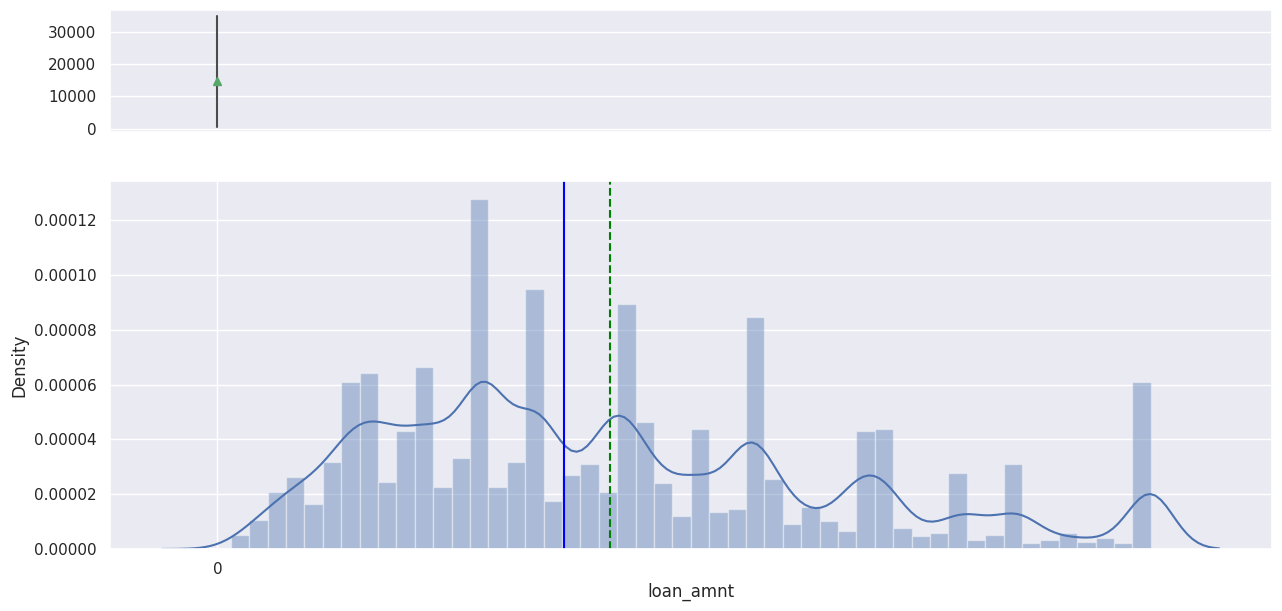

In [ ]:
histogram_boxplot(df.loan_amnt)

### revolving_balance

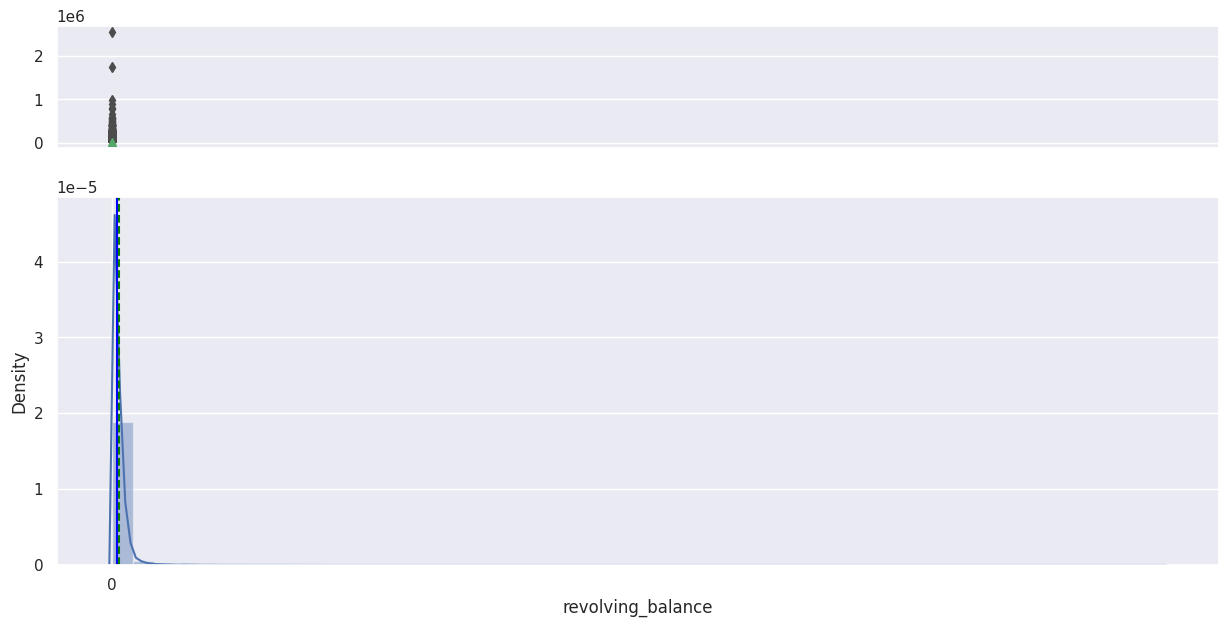

In [ ]:
histogram_boxplot(df.revolving_balance)

### default

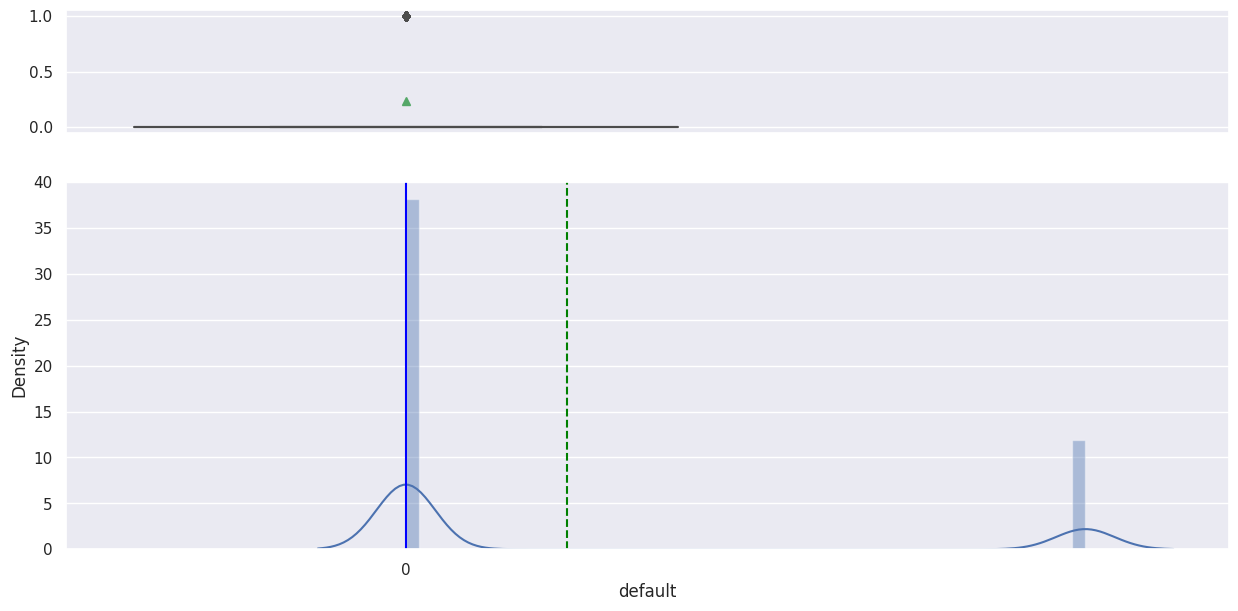

In [ ]:
histogram_boxplot(df.default)

In [ ]:
df.select_dtypes(include='float').columns

Index(['interest_rate', 'annual_income', 'debt_to_income', 'delinq_2yrs',
       'public_records', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')

### interest_rate

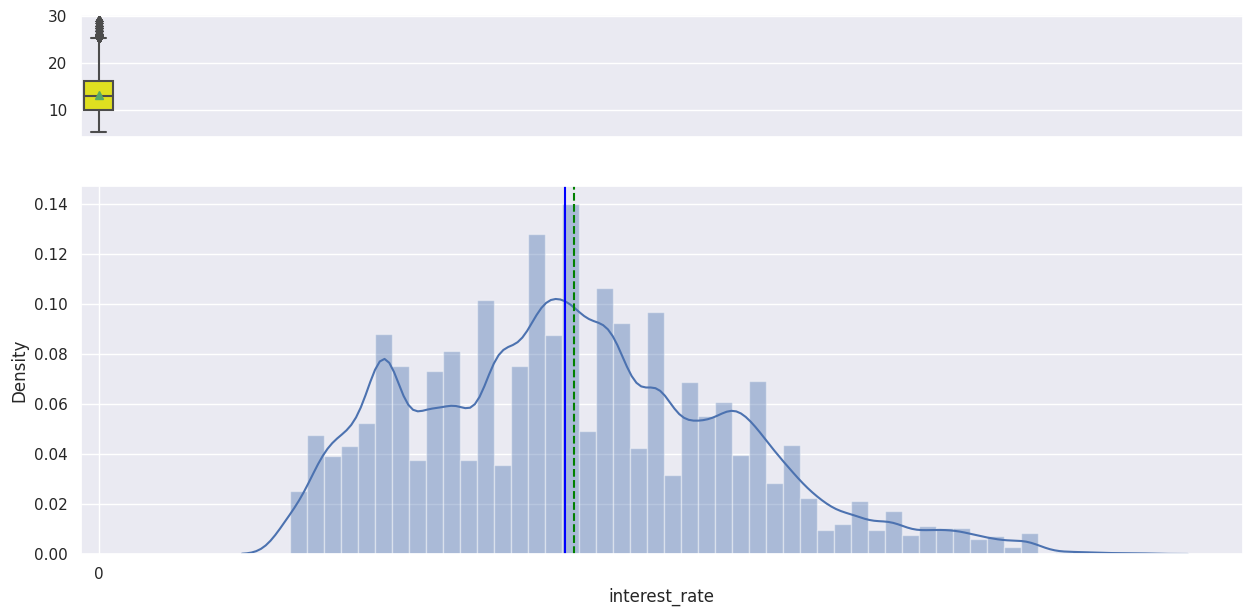

In [ ]:
histogram_boxplot(df.interest_rate)

### annual_income

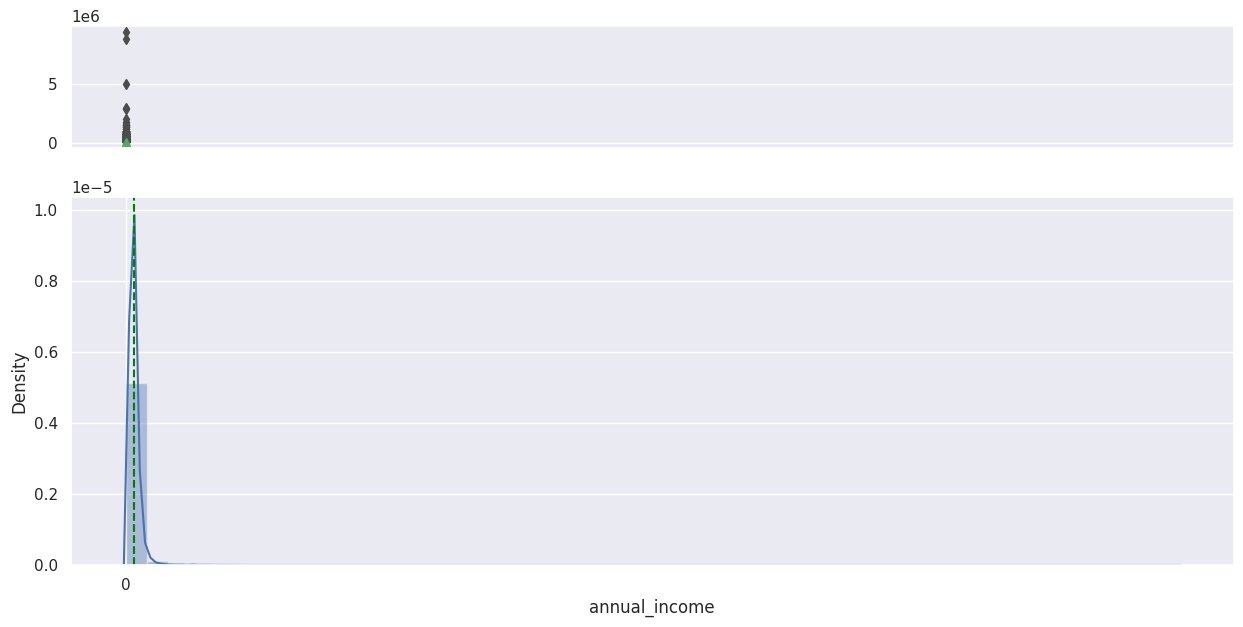

In [ ]:
histogram_boxplot(df.annual_income)

### debt_to_income

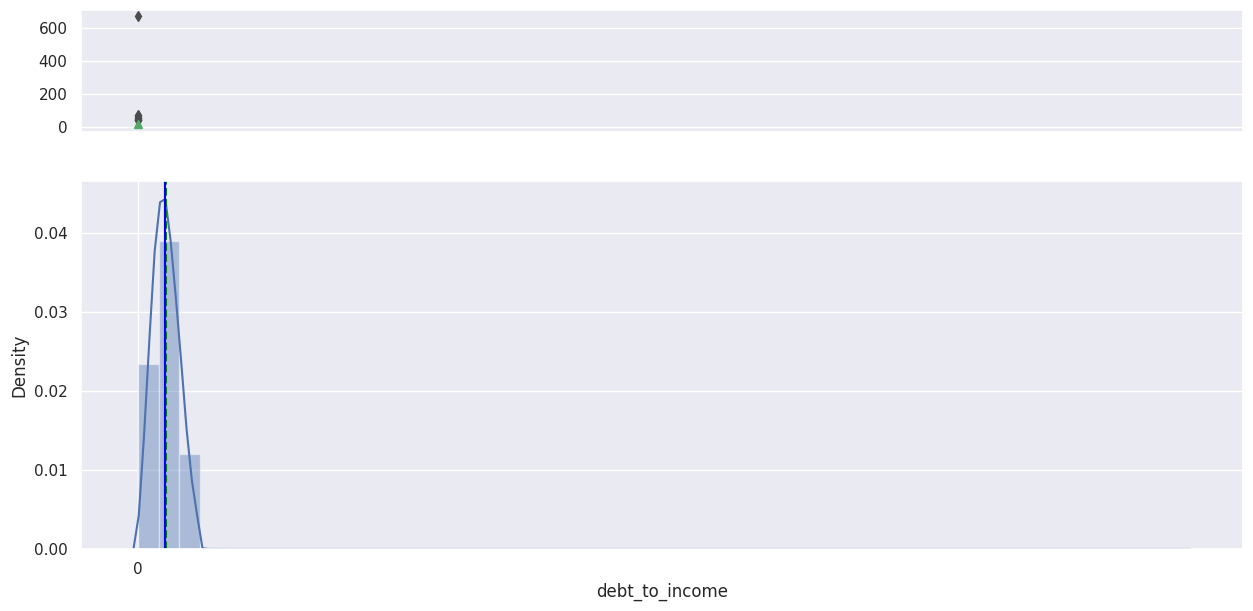

In [ ]:
histogram_boxplot(df.debt_to_income)

### delinq_2yrs

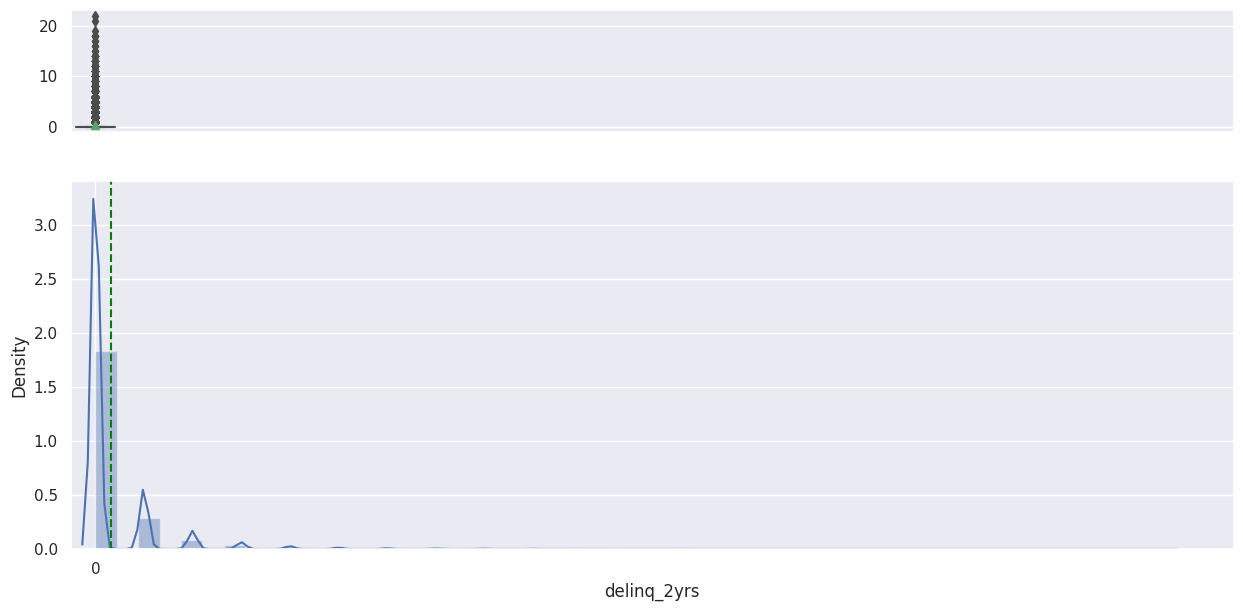

In [ ]:
histogram_boxplot(df.delinq_2yrs)

### public_records

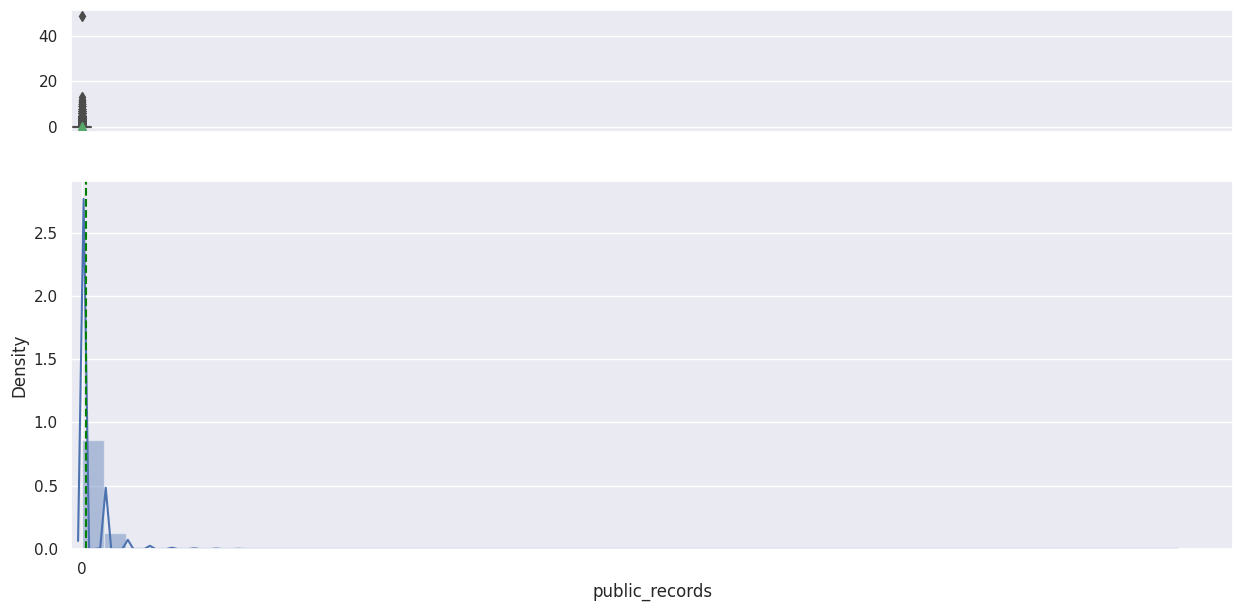

In [ ]:
histogram_boxplot(df.public_records)

### total_acc

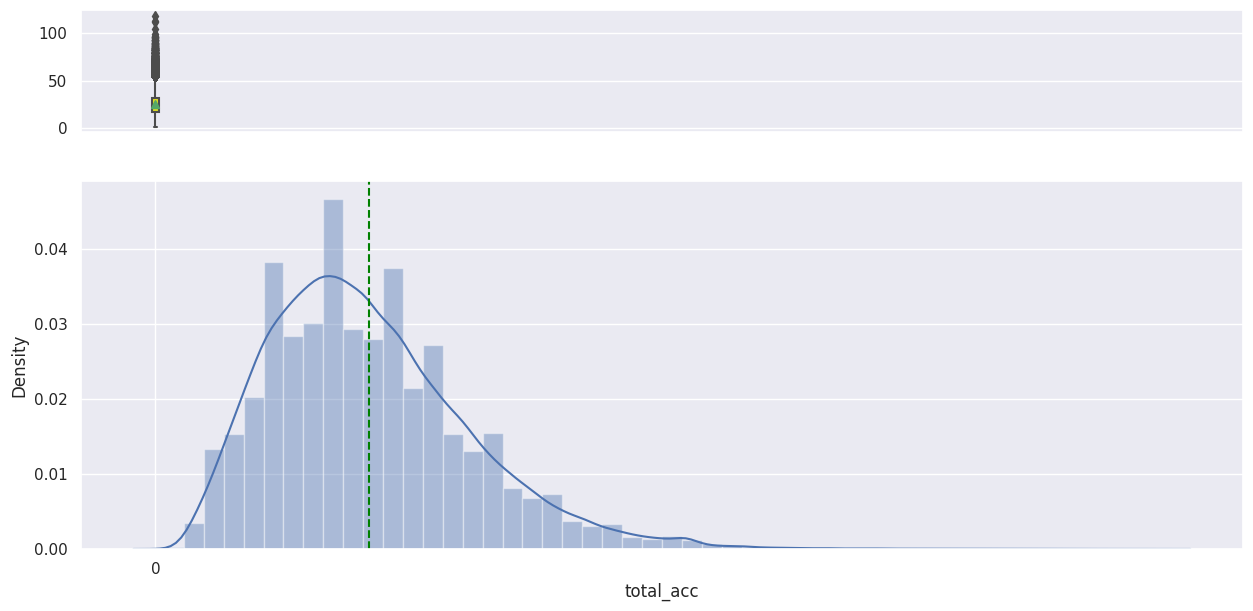

In [ ]:
histogram_boxplot(df.total_acc)

### interest_receive

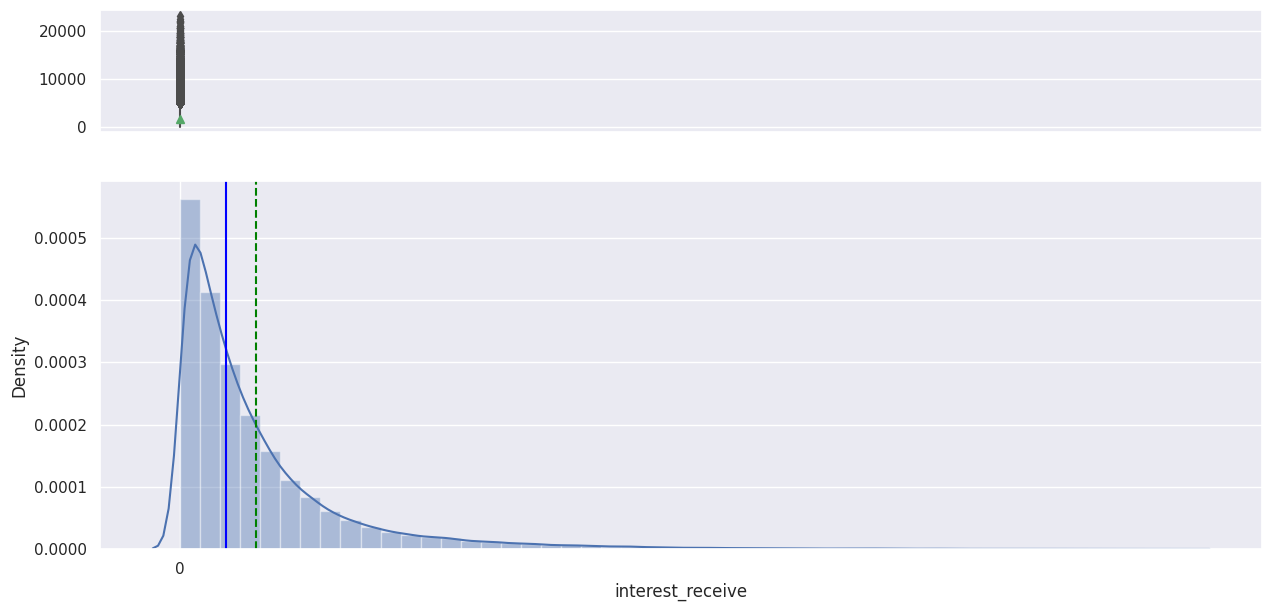

In [ ]:
histogram_boxplot(df.interest_receive)

### last_week_pay

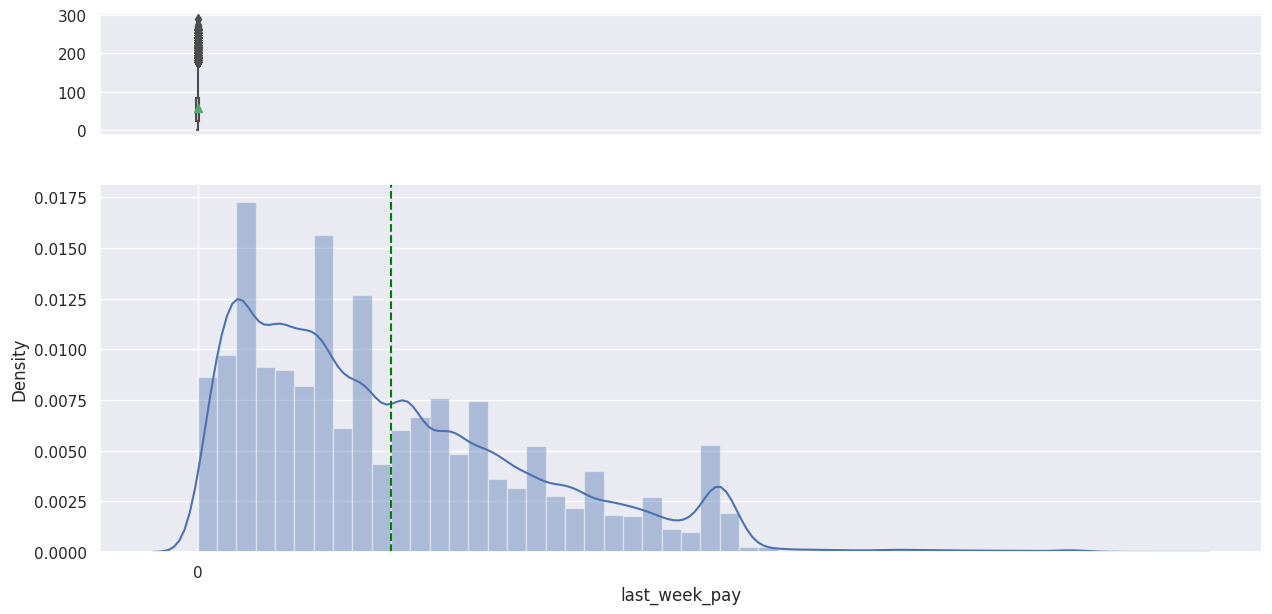

In [ ]:
histogram_boxplot(df.last_week_pay)

### total_current_balance

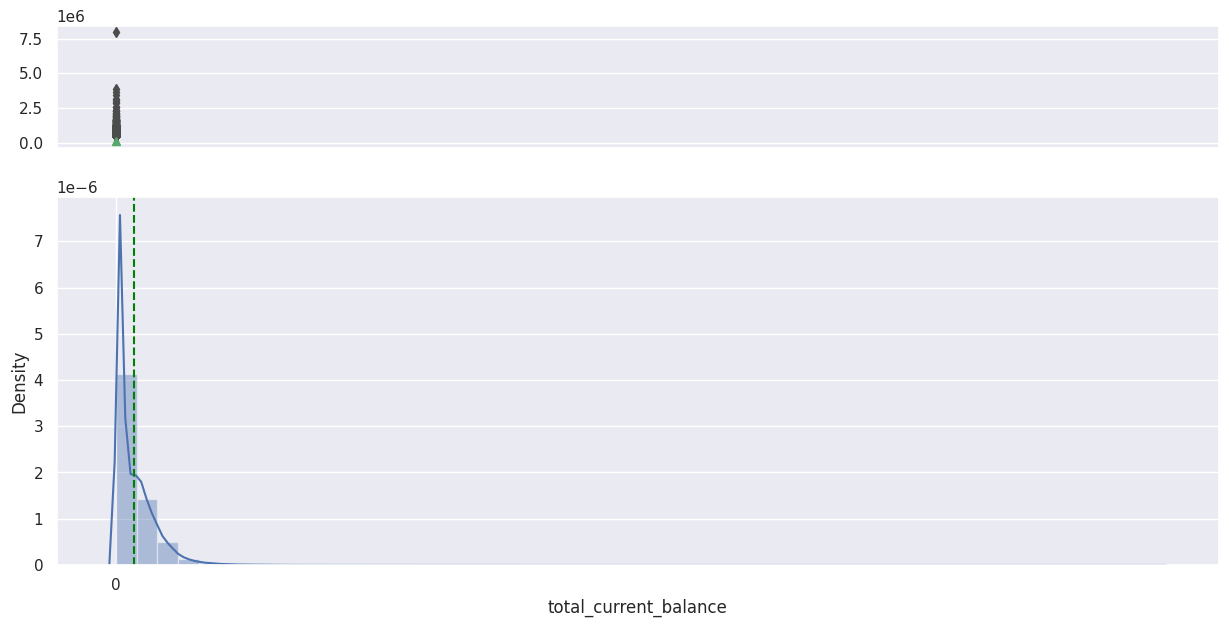

In [ ]:
histogram_boxplot(df.total_current_balance)

### total_revolving_limit

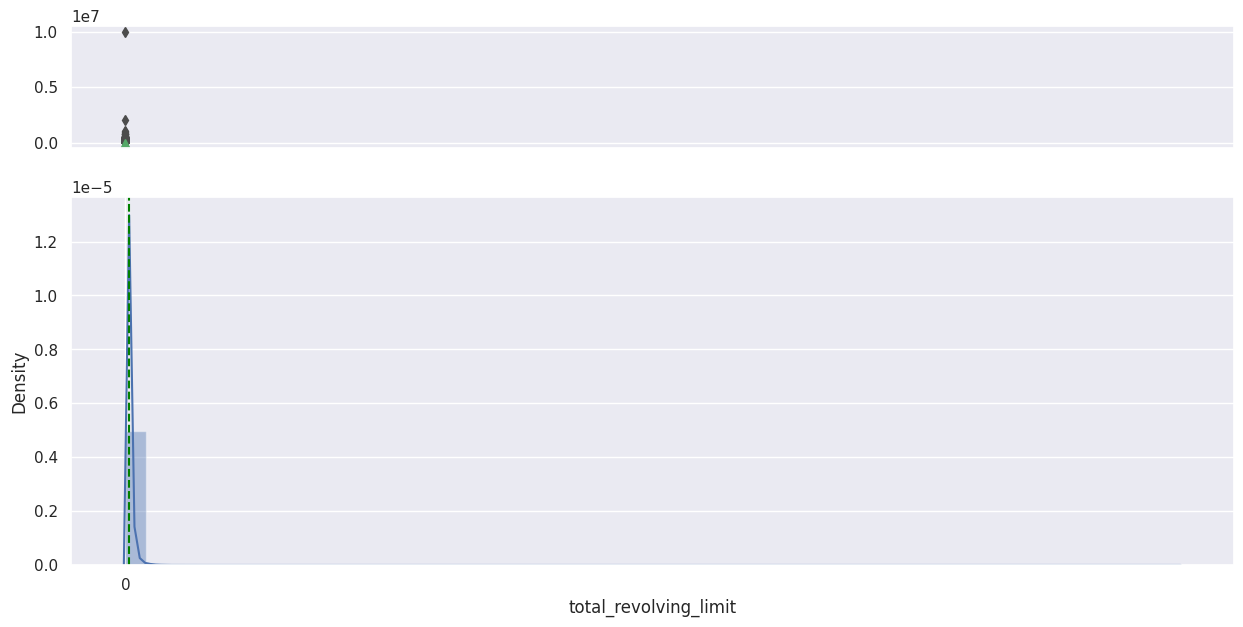

In [ ]:
histogram_boxplot(df.total_revolving_limit)

### default

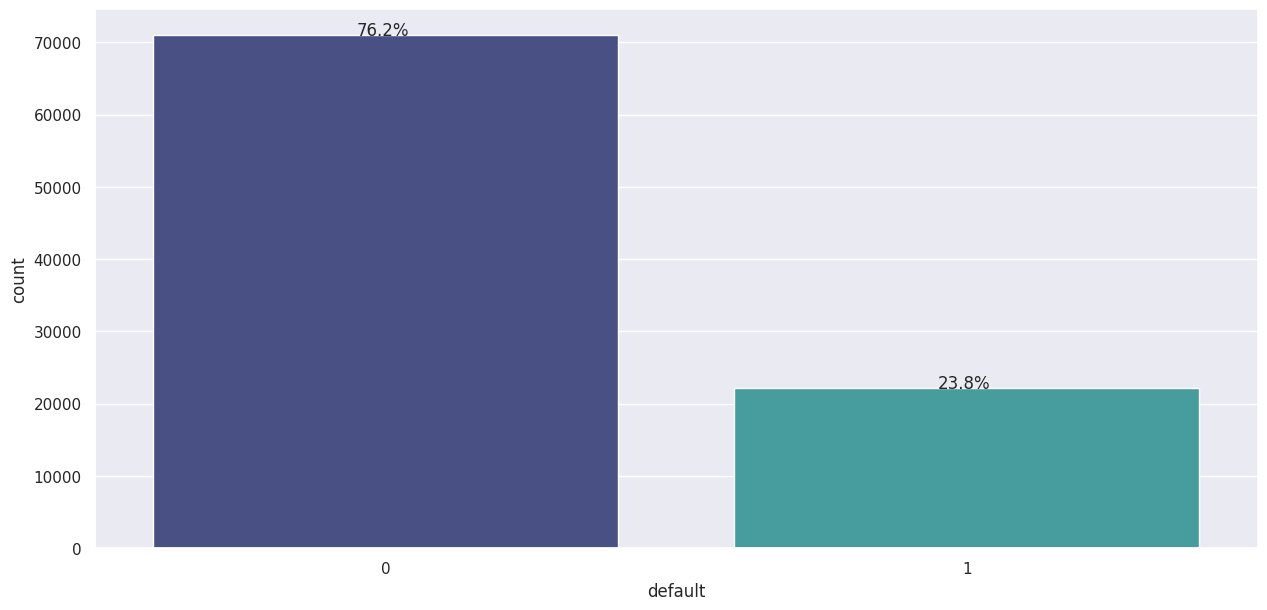

In [ ]:
perc_on_bar(df.default)

### delinq_2yrs

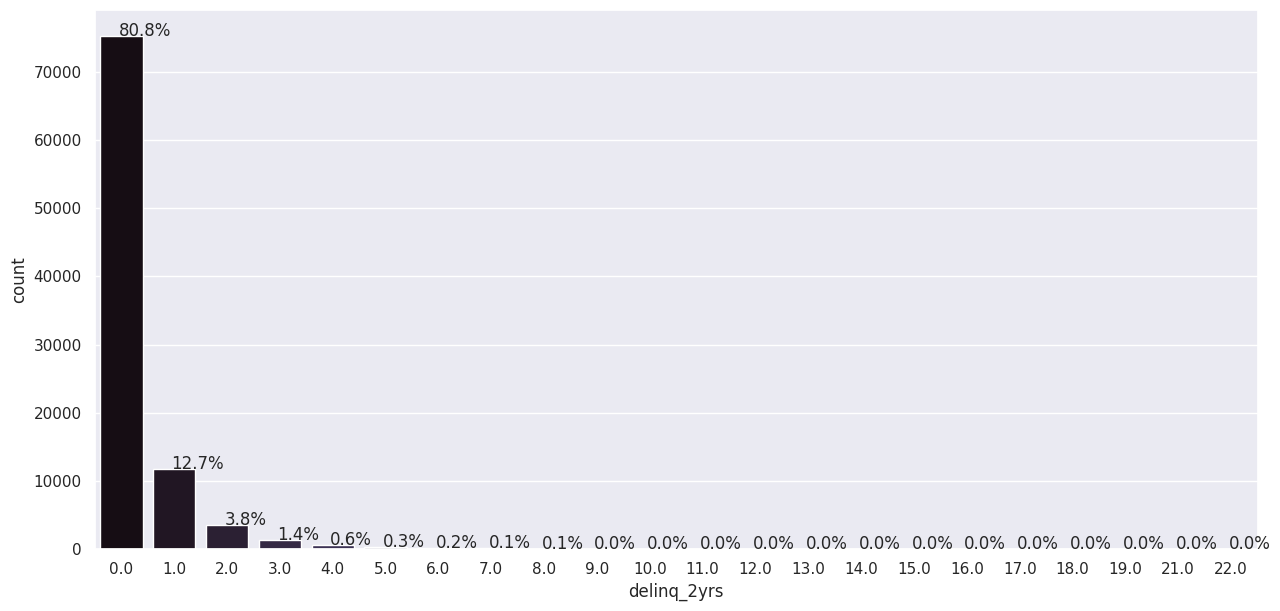

In [ ]:
perc_on_bar(df.delinq_2yrs)

### public_records

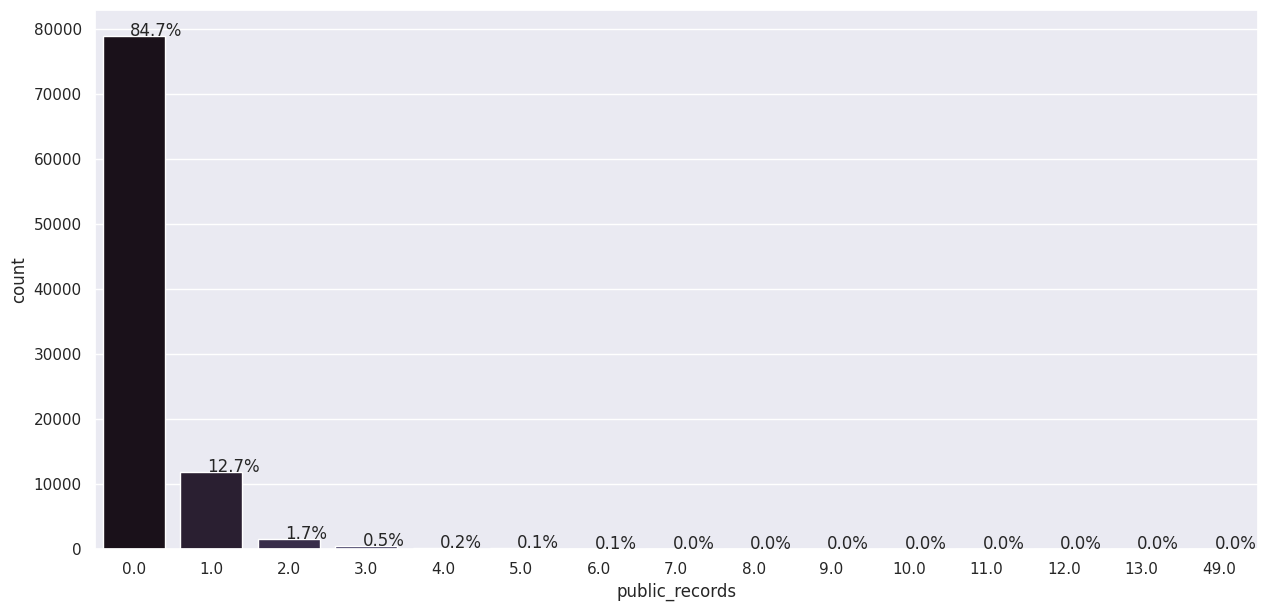

In [ ]:
perc_on_bar(df.public_records)

### loan_term

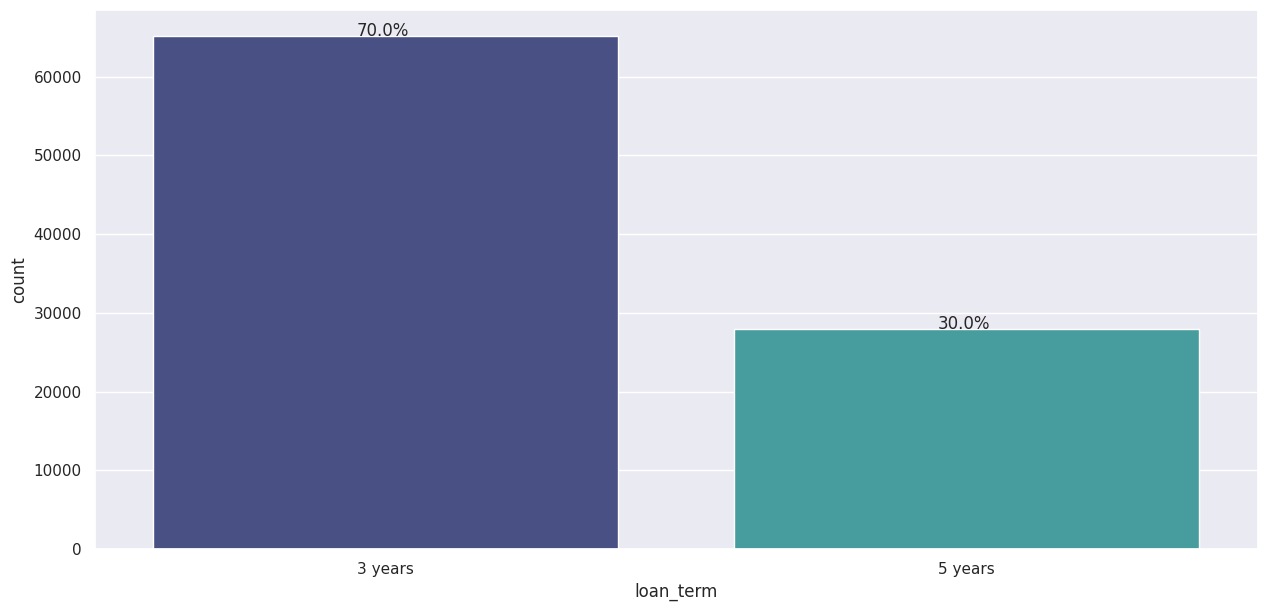

In [ ]:
perc_on_bar(df.loan_term)

### loan_grade

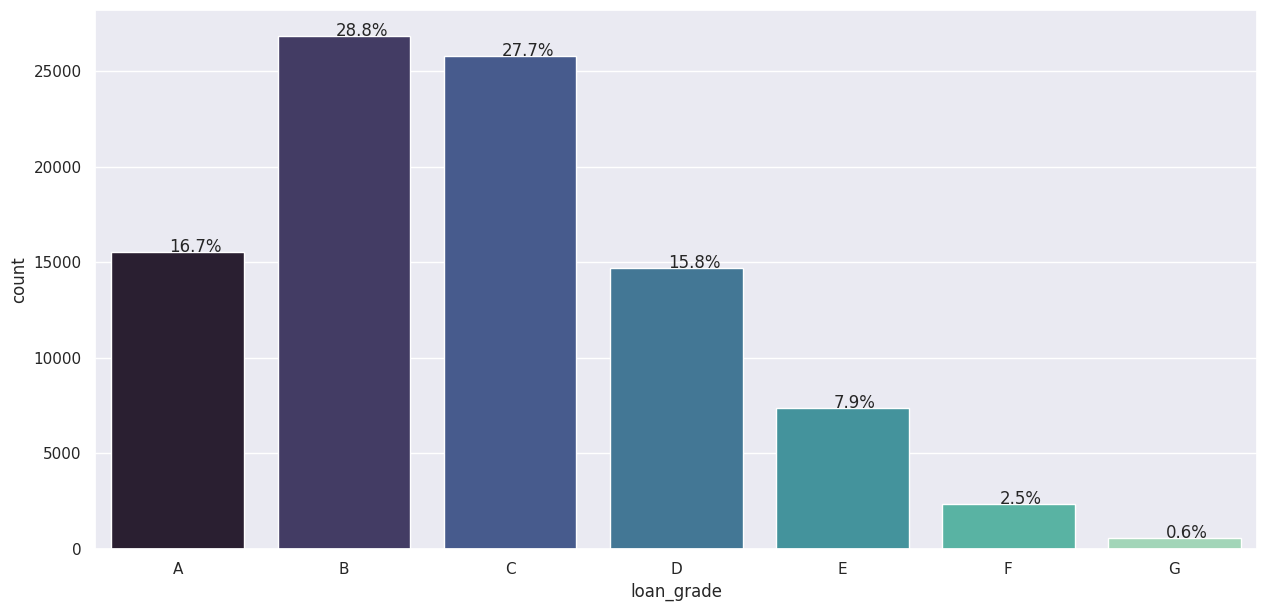

In [ ]:
perc_on_bar(df.loan_grade)

### loan_subgrade

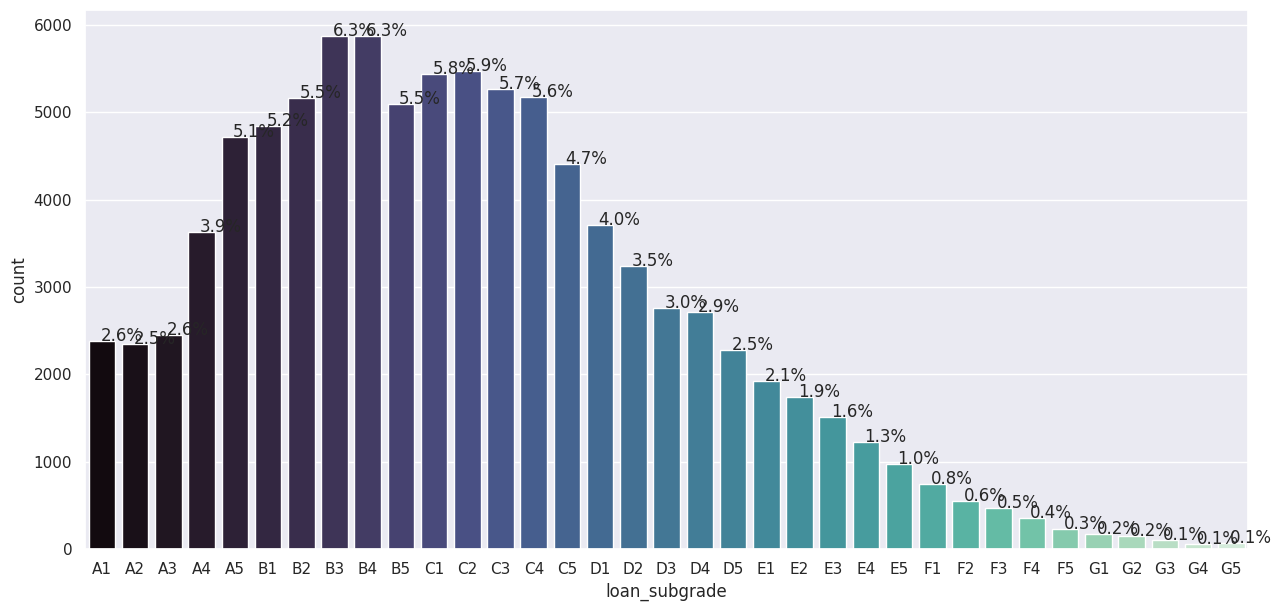

In [ ]:
perc_on_bar(df.loan_subgrade)

### job_experience

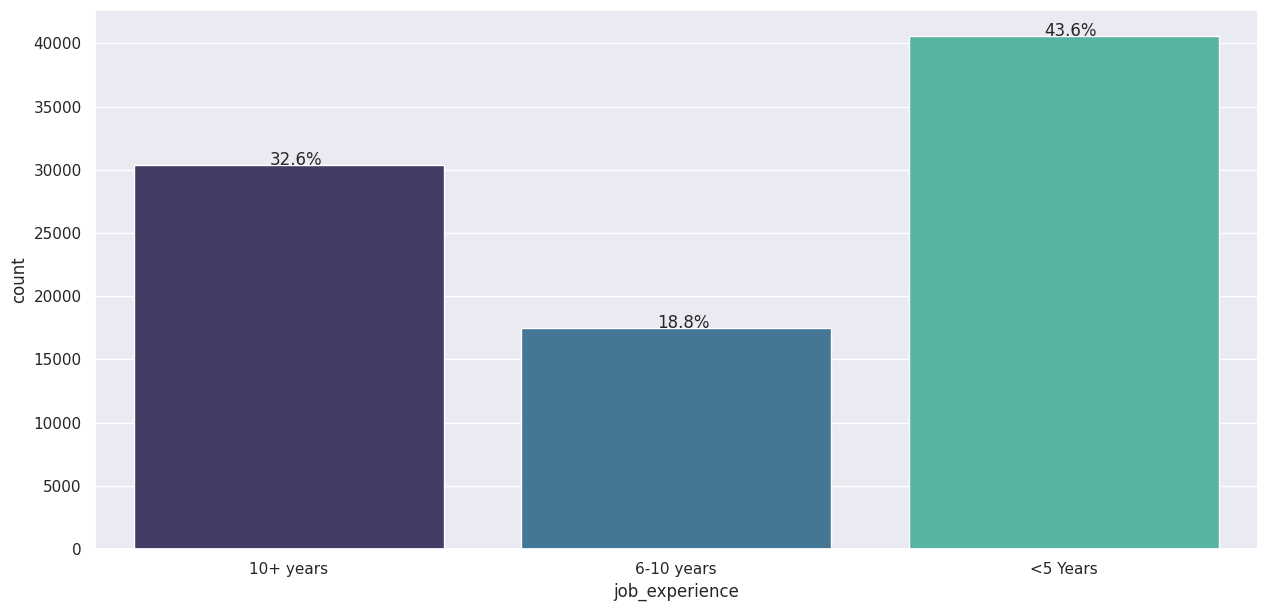

In [ ]:
perc_on_bar(df.job_experience)

### home_ownership

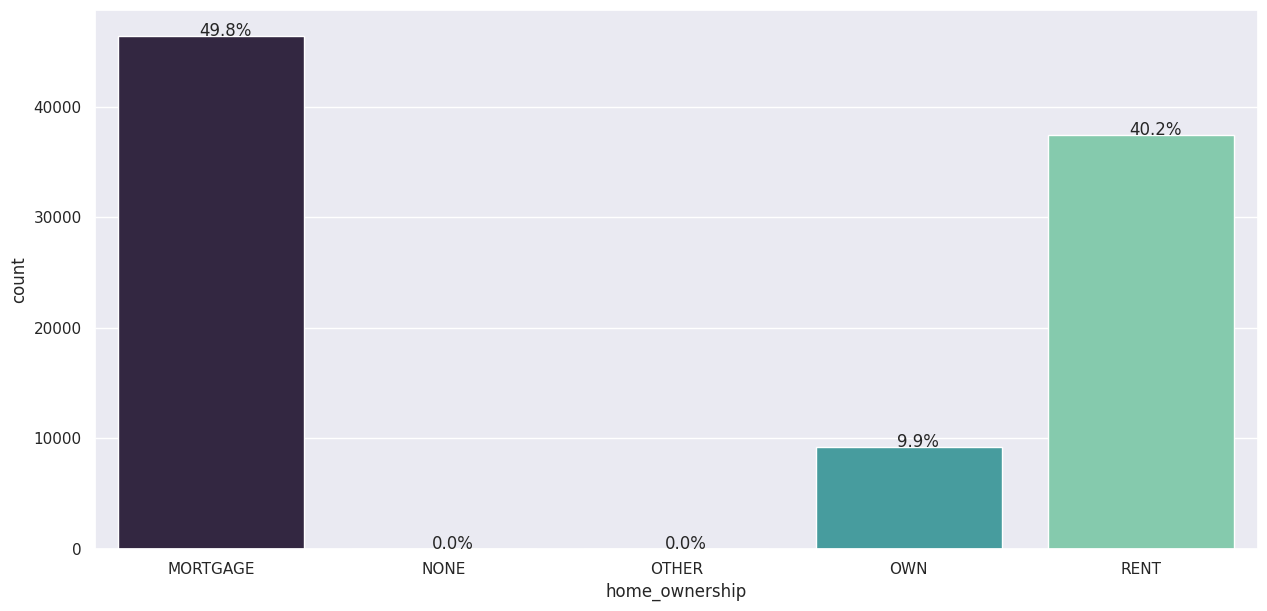

In [ ]:
perc_on_bar(df.home_ownership)

### income_verification_status

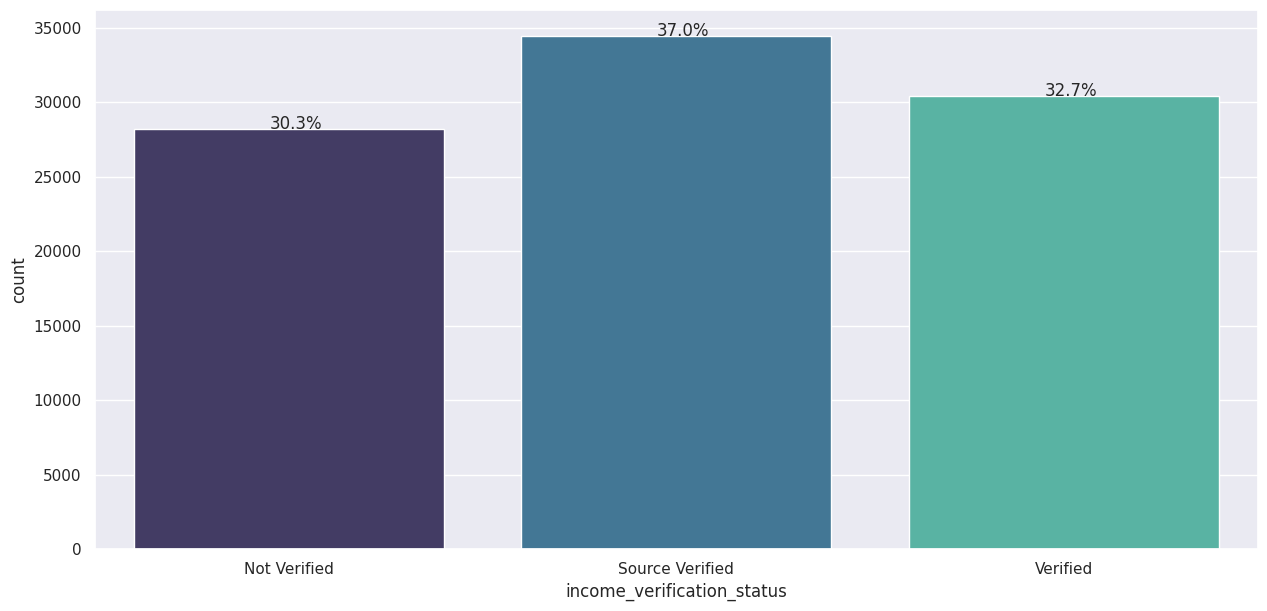

In [ ]:
perc_on_bar(df.income_verification_status)

### loan_purpose

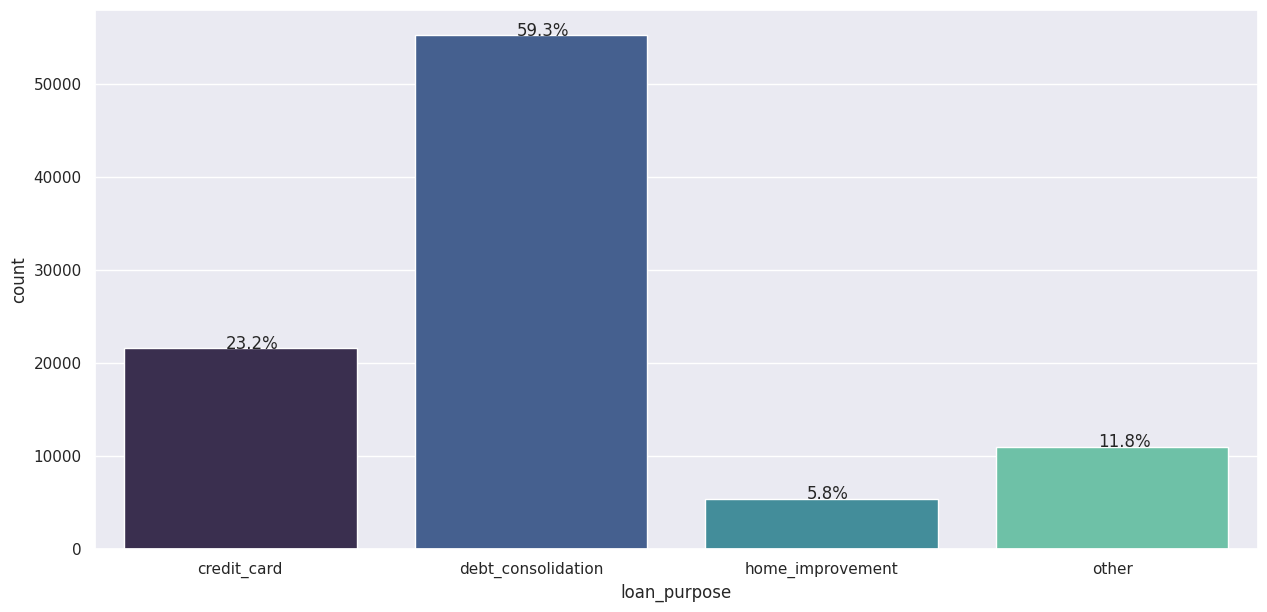

In [ ]:
perc_on_bar(df.loan_purpose)

### state_code

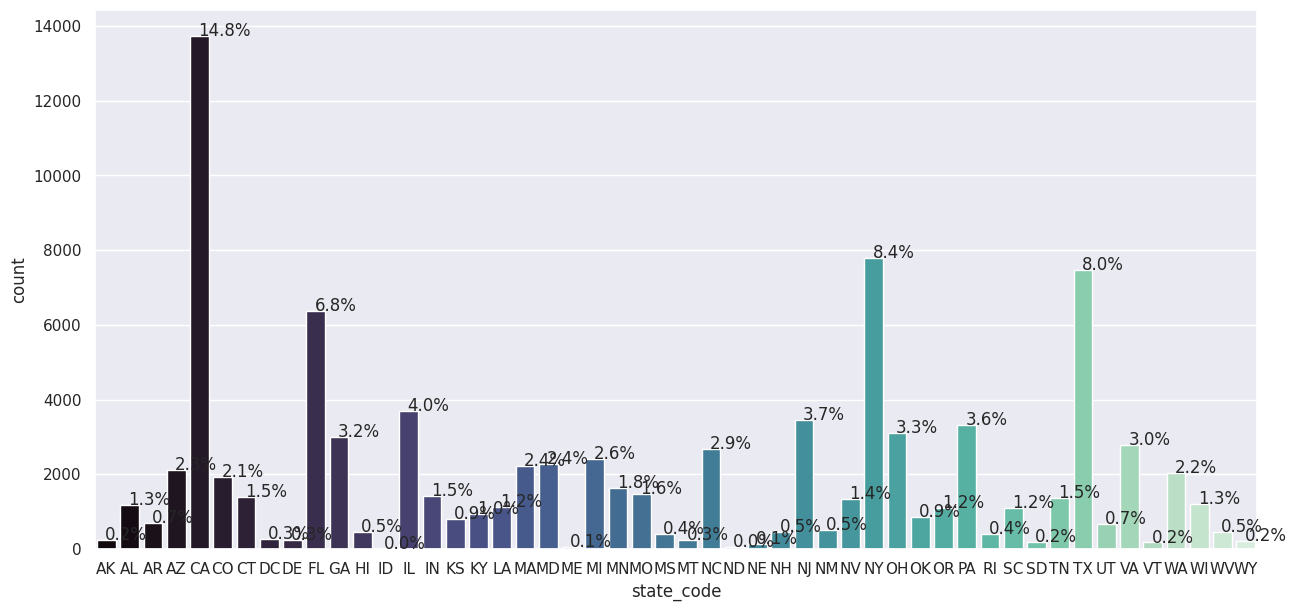

In [ ]:
perc_on_bar(df.state_code)

### application_type

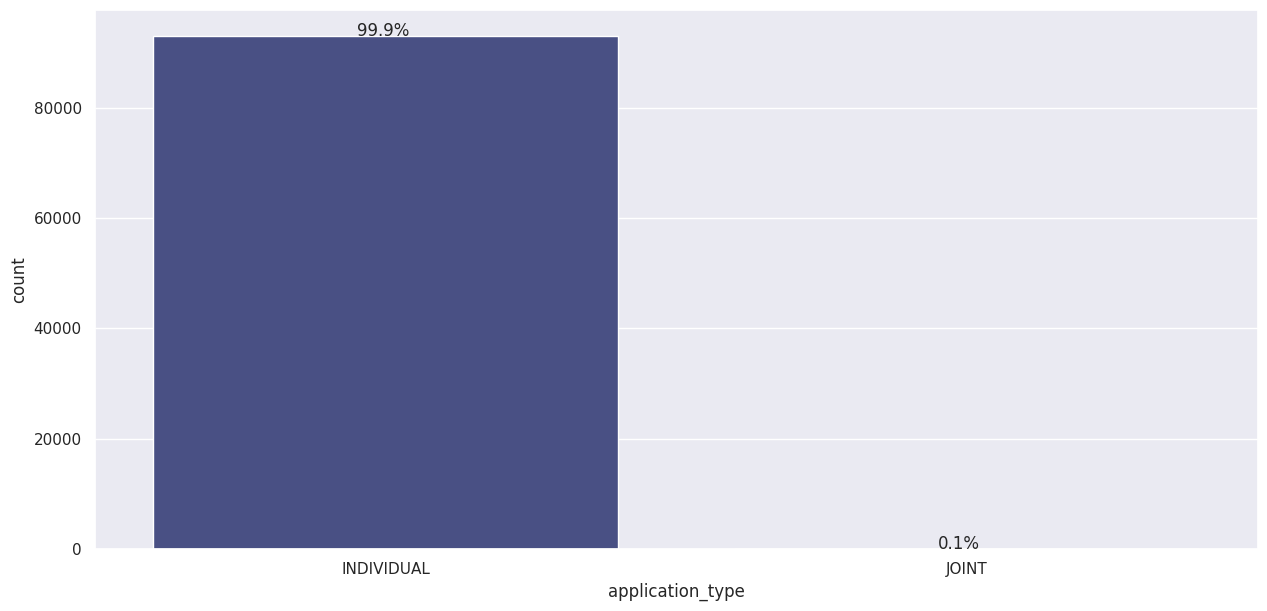

In [ ]:
perc_on_bar(df.application_type)

### Bivariate Analysis

In [ ]:
## Function to plot stacked bar chart
def stacked_plot(x, y, show_df=True):
    """
    Shows stacked plot from x and y pandas data series
    x: pandas data series
    y: pandas data series
    show_df: flag to show dataframe above plot (default=True)
    """
    if show_df == True:
        info = pd.crosstab(x, y, margins=True)
        info['% - 0'] = round(info[0]/info['All']*100, 2)
        info['% - 1'] = round(info[1]/info['All']*100, 2)
        display(info)

    pd.crosstab(x, y, normalize='index').plot(kind='bar', stacked=True, figsize=(10,5));

In [ ]:
def show_boxplots(cols: list, feature: str, show_fliers=True, data=df): #method call to show bloxplots
    """
    Shows boxplots from pandas data series
    cols: list of column names
    feature: dataframe categorical feature
    """
    n_rows = math.ceil(len(cols)/3)
    plt.figure(figsize=(15, n_rows*5))
    for i, variable in enumerate(cols):
        plt.subplot(n_rows, 3, i+1)
        if show_fliers:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=True)
        else:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=False)
        plt.tight_layout()
        plt.title(variable, fontsize=12)
    plt.show()

In [ ]:
### Function to plot distributions and Boxplots of customers
def plot_target(x, target='default'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Distribution of DEFAULT')
    sns.distplot(data[(data[target] == 1)][x], ax=axs[0,0], color='teal')
    axs[0, 1].set_title('Distribution of NON-DEFAULT')
    sns.distplot(data[(data[target] == 0)][x],ax=axs[0,1], color='orange')
    axs[1,0].set_title('Boxplot w.r.t default-flag')
    sns.boxplot(data[target],data[x],ax=axs[1,0], palette='mako')
    axs[1,1].set_title('Boxplot w.r.t default-flag - Without outliers')
    sns.boxplot(data[target],data[x], ax=axs[1,1], showfliers=False, palette='mako')
    plt.tight_layout()
    plt.show()

### Heat map

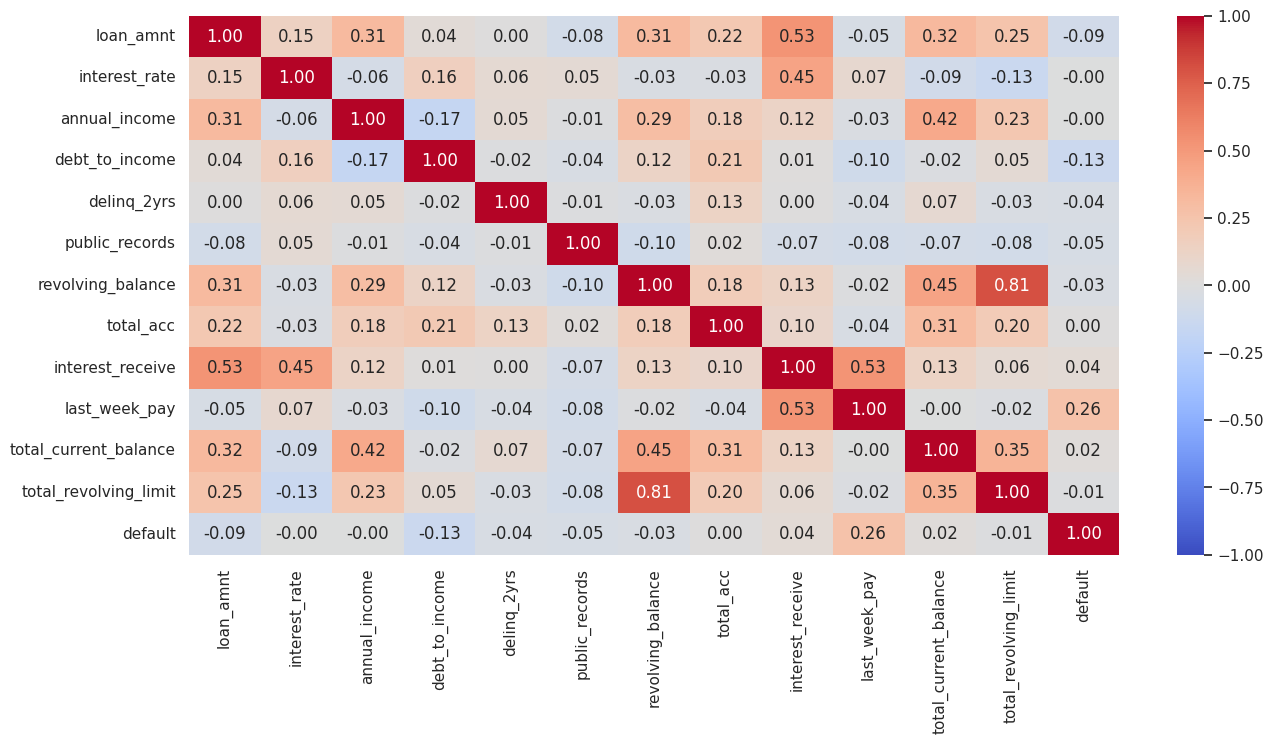

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='coolwarm');

In [ ]:
#sns.pairplot(
    #data=df,
   # hue='default',
    #palette='husl',
    #plot_kws={'alpha': 0.5}
#);

### default vs loan_term

In [ ]:
#stacked_plot(df.loan_term, df.default)

### default vs loan_grade

In [ ]:
#stacked_plot(df.loan_grade, df.default)

### default vs loan_subgrade

In [ ]:
#stacked_plot(df.loan_subgrade, df.default)

### default vs job_experience

In [ ]:
#stacked_plot(df.job_experience, df.default)

### default vs home_ownership

In [ ]:
#stacked_plot(df.home_ownership, df.default)

### default vs income_verification_status

In [ ]:
#stacked_plot(df.income_verification_status, df.default)

### default vs loan_purpose


In [ ]:
#stacked_plot(df.loan_purpose, df.default)

### default vs state_code

In [ ]:
#stacked_plot(df.state_code, df.default)

In [ ]:
#cols = df.select_dtypes(include=['integer', 'float']).columns.tolist()
#cols.remove('default')
#print(' With outliers','\n','*'*50)
#show_boxplots(cols=cols, feature='default')

In [ ]:
#print(' Without outliers','\n','*'*50)
#show_boxplots(cols=cols, feature='default', show_fliers=False)

### default vs loan_amnt

In [ ]:
#plot_target('loan_amnt')

### default vs interest_rate

In [ ]:
#plot_target('interest_rate')

### default vs annual_income

In [ ]:
#plot_target('annual_income')

### default vs debt_to_income

In [ ]:
#plot_target('debt_to_income')

### default vs delinq_2yrs

In [ ]:
#plot_target('delinq_2yrs')

### default vs public_records

In [ ]:
#plot_target('public_records')

### default vs revolving_balance

In [ ]:
#plot_target('revolving_balance')

### default vs total_acc

In [ ]:
#plot_target('total_acc')

### default vs interest_receive

In [ ]:
#plot_target('interest_receive')

### default vs last_week_pay

In [ ]:
#plot_target('last_week_pay')

### default vs total_current_balance

In [ ]:
#plot_target('total_current_balance')

### default vs total_revolving_limit

In [ ]:
#plot_target('total_revolving_limit')

In [ ]:
#def show_violinplot(cols: list, feature: str, hue=df.default, data=df, show_fliers=True):
    #plt.figure(figsize=(12,10))
    #for i, variable in enumerate(cols):
        #plt.subplot(2, 2, i+1)
        #sns.violinplot(data[feature],
                       #data[variable],
                      # hue=hue,
                      # ci=0,
                       #show_fliers=show_fliers)
        #plt.tight_layout()
        #plt.title(variable);

In [ ]:
#cols = ['loan_amnt', 'interest_rate', 'total_acc', 'last_week_pay']
#show_violinplot(cols, 'loan_term')

In [ ]:
#show_violinplot(cols, 'loan_grade', show_fliers=False)

In [ ]:
#show_violinplot(cols, 'job_experience', show_fliers=False)

In [ ]:
#show_violinplot(cols, 'home_ownership', show_fliers=False)

In [ ]:
#show_violinplot(cols, 'income_verification_status', show_fliers=False)

In [ ]:
#show_violinplot(cols, 'loan_purpose', show_fliers=False)

In [ ]:
#Q1 = data.quantile(0.25) # To find the 25th percentile and 75th percentile.
#Q3 = data.quantile(0.75)
#IQR = Q3 - Q1            # Inter Quantile Range (75th perentile - 25th percentile)
##lower = Q1-1.5 * IQR     # Finding lower and upper bounds for all values. All values outside these bounds are outliers
##upper = Q3+1.5 * IQR
#df_lower = (data.select_dtypes(include=['float64','int64']) < lower)
#df_upper = (data.select_dtypes(include=['float64','int64']) > upper)
#(df_lower | df_upper).sum()/len(data)*100

<a id=processing></a>
## <span style="color:blue">Data Preparation</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [ ]:
df.isnull().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                4702
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
application_type                 0
last_week_pay                 1924
total_current_balance         7386
total_revolving_limit         7386
default                          0
dtype: int64

In [ ]:
for i in df.select_dtypes(include=['category']).columns:
    print('Unique values in', i, 'are :')
    print(df[i].value_counts(dropna=False))
    print('*'*50)

Unique values in loan_term are :
3 years    65211
5 years    27963
Name: loan_term, dtype: int64
**************************************************
Unique values in loan_grade are :
B    26865
C    25787
A    15534
D    14715
E     7378
F     2344
G      551
Name: loan_grade, dtype: int64
**************************************************
Unique values in loan_subgrade are :
B4    5879
B3    5879
C2    5479
C1    5443
C3    5270
C4    5182
B2    5169
B5    5095
B1    4843
A5    4723
C5    4413
D1    3716
A4    3631
D2    3239
D3    2759
D4    2717
A3    2450
A1    2377
A2    2353
D5    2284
E1    1924
E2    1736
E3    1513
E4    1228
E5     977
F1     745
F2     545
F3     465
F4     355
F5     234
G1     174
G2     146
G3     105
G5      66
G4      60
Name: loan_subgrade, dtype: int64
**************************************************
Unique values in job_experience are :
<5 Years      40610
10+ years     30362
6-10 years    17500
NaN            4702
Name: job_experience, dtype: int64

In [ ]:
# df1.home_ownership.replace('NONE','OTHER', inplace=True)
# df1.home_ownership.value_counts().sort_values(ascending=False)

In [ ]:
# df1.income_verification_status.replace('Source Verified','Verified', inplace=True)
# df1.income_verification_status.value_counts().sort_values(ascending=False)

In [ ]:
# df1['state_code'] = df1['state_code'].apply(region_combining)
# df1['state_code'] = df1['state_code'].astype('category')
# df1.state_code.value_counts(dropna=False)

#midwest = ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
#northeast = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
#south = ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK',
#         'SC', 'TN', 'TX', 'VA', 'WV']
#west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

### Missing value treatment

In [ ]:
df1 = df.copy()

In [ ]:
df1.annual_income.fillna(df.annual_income.mean(), inplace=True)
df1.last_week_pay.fillna(df.last_week_pay.mean(), inplace=True)
df1.total_current_balance.fillna(df.total_current_balance.mean(), inplace=True)
df1.total_revolving_limit.fillna(df.total_revolving_limit.mean(), inplace=True)
df1.total_acc.fillna(df.total_acc.mean(), inplace=True)

In [ ]:
job_experience = {'<5 Years':0, '6-10 years':1, '10+ years':2}
df1['job_experience'] = df1['job_experience'].map(job_experience).astype('Int32')

loan_term = {'3 years': 0, '5 years': 1}
df1['loan_term'] = df1['loan_term'].map(loan_term).astype('Int32')

loan_grade = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
df1['loan_grade'] = df1['loan_grade'].map(loan_grade).astype('Int32')

loan_subgrade = {'A1':0,  'A2':1,  'A3':2,  'A4':3,  'A5':4,
                 'B1':5,  'B2':6,  'B3':7,  'B4':8,  'B5':9,
                 'C1':10, 'C2':11, 'C3':12, 'C4':13, 'C5':14,
                 'D1':15, 'D2':16, 'D3':17, 'D4':18, 'D5':19,
                 'E1':20, 'E2':21, 'E3':22, 'E4':23, 'E5':24,
                 'F1':25, 'F2':26, 'F3':27, 'F4':28, 'F5':29,
                 'G1':30, 'G2':31, 'G3':32, 'G4':33, 'G5':34}
df1['loan_subgrade'] = df1['loan_subgrade'].map(loan_subgrade).astype('Int32')

home_ownership = {'MORTGAGE':0, 'RENT':1, 'OWN':2, 'OTHER':3, 'NONE':4}
df1['home_ownership'] = df1['home_ownership'].map(home_ownership).astype('Int32')

income_verification_status = {'Verified':0, 'Not Verified':1, 'Source Verified':2}
df1['income_verification_status'] = df1['income_verification_status'].map(income_verification_status).astype('Int32')

loan_purpose = {'debt_consolidation': 0, 'credit_card':1, 'home_improvement': 2, 'other': 3}
df1['loan_purpose'] = df1['loan_purpose'].map(loan_purpose).astype('Int32')

application_type = {'INDIVIDUAL': 0, 'JOINT':1}
df1['application_type'] = df1['application_type'].map(application_type).astype('Int32')

state_code = {'AK':0,  'AL':1,  'AR':2,  'AZ':3,  'CA':4 , 'CO':5,  'CT':6,  'DC':7,  'DE':8,
              'FL':9,  'GA':10, 'HI':11, 'IA':12, 'ID':13, 'IL':14, 'IN':15, 'KS':16, 'KY':17,
              'LA':18, 'MA':19, 'MD':20, 'ME':21, 'MI':22, 'MN':23, 'MO':24, 'MS':25, 'MT':26,
              'NC':27, 'ND':28, 'NE':29, 'NH':30, 'NJ':31, 'NM':32, 'NV':33, 'NY':34, 'OH':35,
              'OK':36, 'OR':37, 'PA':38, 'RI':39, 'SC':40, 'SD':41, 'TN':42, 'TX':43, 'UT':44,
              'VA':45, 'VT':46, 'WA':47, 'WI':48, 'WV':49, 'WY':50}
df1['state_code'] = df1['state_code'].map(state_code).astype('Int32')

In [ ]:
df1.head()

,loan_amnt,loan_term,interest_rate,loan_grade,loan_subgrade,job_experience,home_ownership,annual_income,income_verification_status,loan_purpose,...,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,application_type,last_week_pay,total_current_balance,total_revolving_limit,default
0,9000,0,9.170,1,6,0,2,85000.000,1,0,...,0.000,0.000,39519,20.000,59.600,0,4.000,95493.000,84100.000,0
1,18000,0,13.650,2,10,0,2,64000.000,0,0,...,0.000,1.000,9783,24.000,3348.250,0,95.000,185433.000,13500.000,0
2,16000,0,7.260,0,3,0,0,150000.000,2,0,...,2.000,0.000,13641,27.000,276.690,0,13.000,180519.000,19300.000,0
3,25000,0,13.990,2,13,<NA>,0,59800.000,0,0,...,0.000,0.000,35020,35.000,1106.720,0,17.000,183208.000,55400.000,0
4,17000,0,6.390,0,1,2,0,72000.000,2,1,...,0.000,0.000,23990,26.000,725.290,0,39.000,23990.000,81300.000,0


In [ ]:
imputer = KNNImputer(n_neighbors=5)

In [ ]:
X = df1.drop(['default'], axis=1)
y = df1['default']

In [ ]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)
print(X_train.shape, X_test.shape)

(65221, 21) (27953, 21)


In [ ]:
#Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

In [ ]:
#Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test),columns=X_test.columns)

In [ ]:
#Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print('-'*30)
print(X_test.isna().sum())

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
dtype: int64
------------------------------
loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status  

In [ ]:
## Function to inverse the encoding
def inverse_mapping(x,y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype('category')
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype('category')

In [ ]:
inverse_mapping(job_experience,'job_experience')
inverse_mapping(loan_term,'loan_term')
inverse_mapping(loan_grade,'loan_grade')
#inverse_mapping(loan_subgrade,'loan_subgrade')
inverse_mapping(home_ownership,'home_ownership')
inverse_mapping(income_verification_status,'income_verification_status')
inverse_mapping(loan_purpose,'loan_purpose')
inverse_mapping(application_type,'application_type')
#inverse_mapping(state_code,'state_code')

In [ ]:
cols = X_train.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(X_train[i].value_counts(dropna=False))
    print('*'*30)

3 years    45758
5 years    19463
Name: loan_term, dtype: int64
******************************
B    18860
C    18022
A    10937
D    10225
E     5182
F     1624
G      371
Name: loan_grade, dtype: int64
******************************
<5 Years      29464
10+ years     21392
6-10 years    14365
Name: job_experience, dtype: int64
******************************
MORTGAGE    32466
RENT        26216
OWN          6526
OTHER          11
NONE            2
Name: home_ownership, dtype: int64
******************************
Source Verified    24162
Verified           21404
Not Verified       19655
Name: income_verification_status, dtype: int64
******************************
debt_consolidation    38711
credit_card           15058
other                  7656
home_improvement       3796
Name: loan_purpose, dtype: int64
******************************
INDIVIDUAL    65188
JOINT            33
Name: application_type, dtype: int64
******************************


### Encoding categorical variables

In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_test.shape)

(65221, 33) (27953, 33)


In [ ]:
X_train.columns

Index(['loan_amnt', 'interest_rate', 'loan_subgrade', 'annual_income',
       'state_code', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'loan_term_5 years',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'job_experience_6-10 years',
       'job_experience_<5 Years', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'income_verification_status_Source Verified',
       'income_verification_status_Verified',
       'loan_purpose_debt_consolidation', 'loan_purpose_home_improvement',
       'loan_purpose_other', 'application_type_JOINT'],
      dtype='object')

<a id=modelbuilding></a>
## <span style="color:blue">Model Building</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [ ]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model, flag=True):
    '''
    model : classifier to predict values of X
    flag: Flag to print metric score dataframe. (default=True)
    '''
    # defining an empty list to store train and test results
    scores = []
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    train_f1 = f1_score(y_train,pred_train)
    test_f1 = f1_score(y_test,pred_test)
    scores.extend(
        (
            train_acc, test_acc,
            train_recall, test_recall,
            train_precision, test_precision,
            train_f1, test_f1
        )
    )

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        metric_names = [
            'Train Accuracy', 'Test Accuracy', 'Train Recall', 'Test Recall',
            'Train Precision', 'Test Precision', 'Train F1-Score', 'Test F1-Score'
        ]
        cols = ['Metric', 'Score']
        records = [(name, score) for name, score in zip(metric_names, scores)]
        display(pd.DataFrame.from_records(records, columns=cols, index='Metric').T)

    return scores # returning the list with train and test scores

In [ ]:
## Function to create confusion matrix
def make_confusion_matrix(model,  y_actual, labels=[1, 0], xtest=X_test):
    """
    model : classifier to predict values of X
    y_actual : ground truth
    """
    y_predict = model.predict(xtest)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index=["Yes", "No"], columns=["Yes", "No"])

    group_counts = [f"{value:0.0f}" for value in cm.flatten()]
    group_percentages = [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)]

    labels = [f"{gc}\n{gp}" for gc, gp in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize = (10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='')
    plt.ylabel("Actual", fontsize=14)
    plt.xlabel("Predicted", fontsize=14);

In [ ]:
def show_model_performance(model: list, model_names: list):
    results = []
    for model, name in zip(models, model_names):
        (acc_train, acc_test,
         recall_train, recall_test,
         precision_train, precision_test,
         f1_train, f1_test) = get_metrics_score(model, False)

        results.append((name, acc_train, acc_test, recall_train, recall_test,
                    precision_train, precision_test, f1_train, f1_test))

    cols = [
        'Model', 'Train Acc', 'Test Accuracy', 'Train Recall',
        'Test Recall', 'Train Precision', 'Test Precision',
        'Train F1-Score', 'Test F1-Score'
    ]

    comparison_frame = pd.DataFrame.from_records(results, columns=cols, index='Model')
    # Sorting models in decreasing order of test f1-score
    display(comparison_frame.sort_values(by='Test F1-Score', ascending=False))

<a id=cross_validation_scores></a>
## <span style="color:blue">Cross Validation Scores</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(random_state=1)

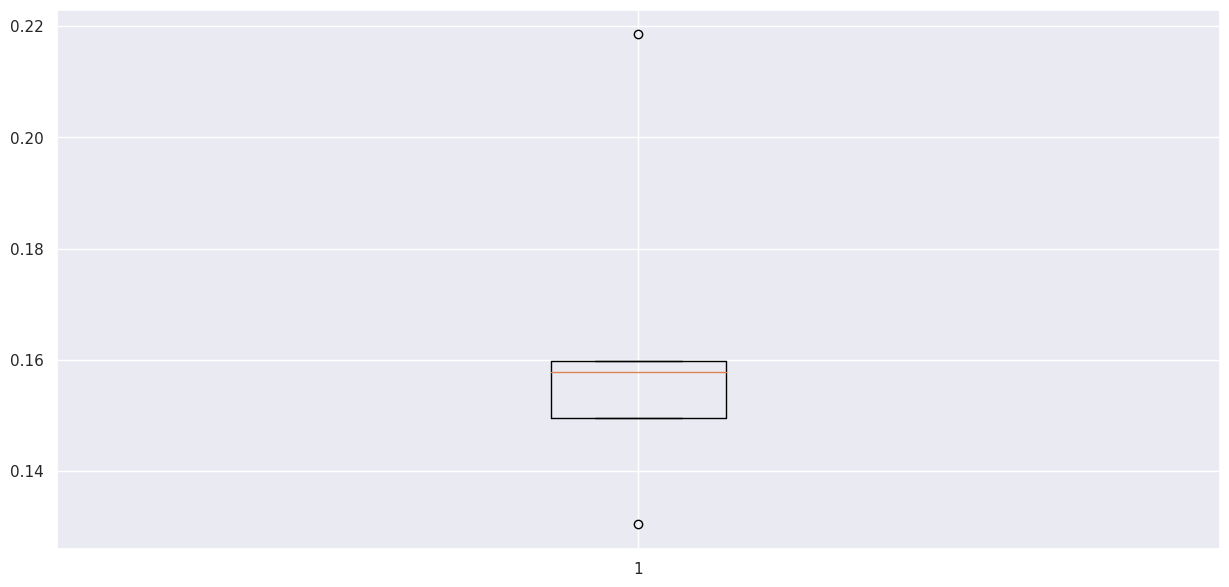

In [ ]:
scoring = 'recall'
#Setting number of splits equal to 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_result_bfr = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr);

Metric,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1-Score,Test F1-Score
Score,0.778,0.779,0.150,0.151,0.644,0.655,0.244,0.246


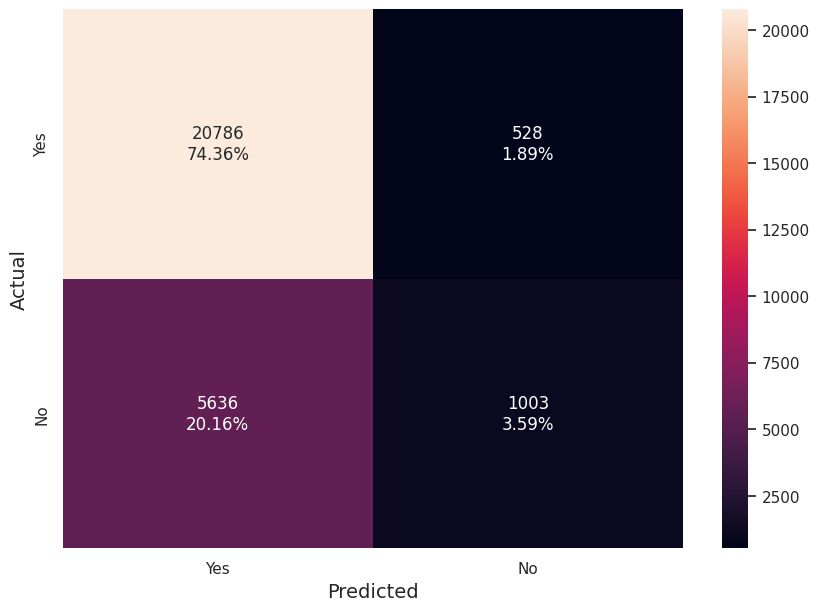

In [ ]:
get_metrics_score(lr)
make_confusion_matrix(lr, y_test)

### Oversampling train data

In [ ]:
from imblearn.over_sampling import SMOTE

print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))

print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 15490
Before UpSampling, counts of label 'No': 49731 

After UpSampling, counts of label 'Yes': 49731
After UpSampling, counts of label 'No': 49731 

After UpSampling, the shape of train_X: (99462, 33)
After UpSampling, the shape of train_y: (99462,) 



In [ ]:
log_reg_over = LogisticRegression(random_state=1)

# Training the basic logistic regression model with the training set
log_reg_over.fit(X_train_over, y_train_over)

LogisticRegression(random_state=1)

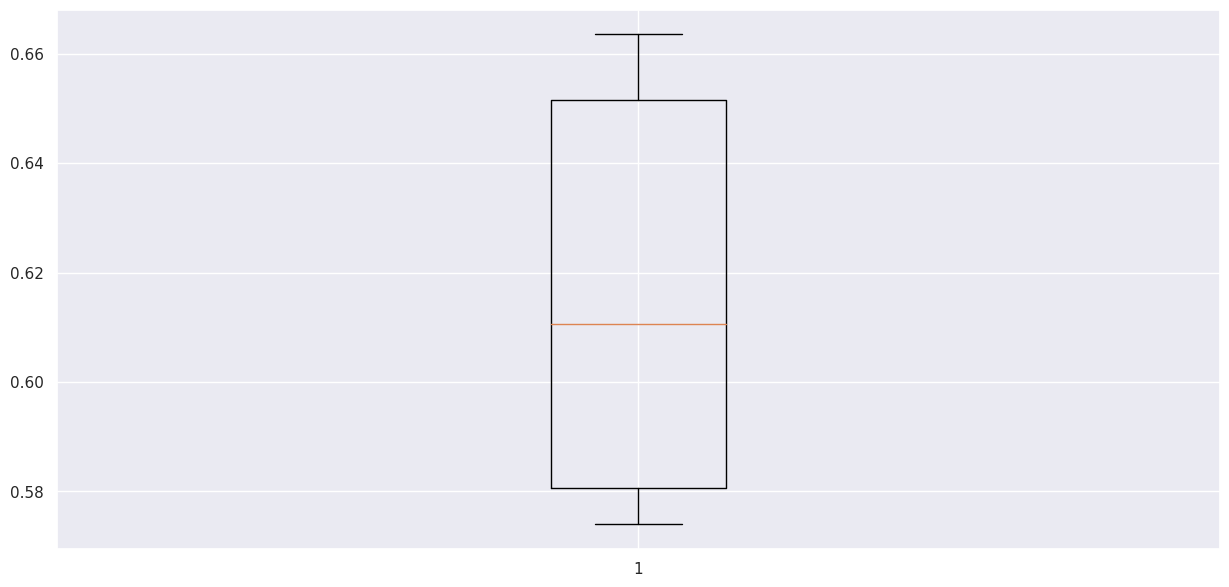

In [ ]:
scoring = 'recall'
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)     #Setting number of splits equal to 5
cv_result_over = cross_val_score(estimator=log_reg_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_over);

Metric,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1-Score,Test F1-Score
Score,0.653,0.653,0.561,0.562,0.354,0.354,0.434,0.435


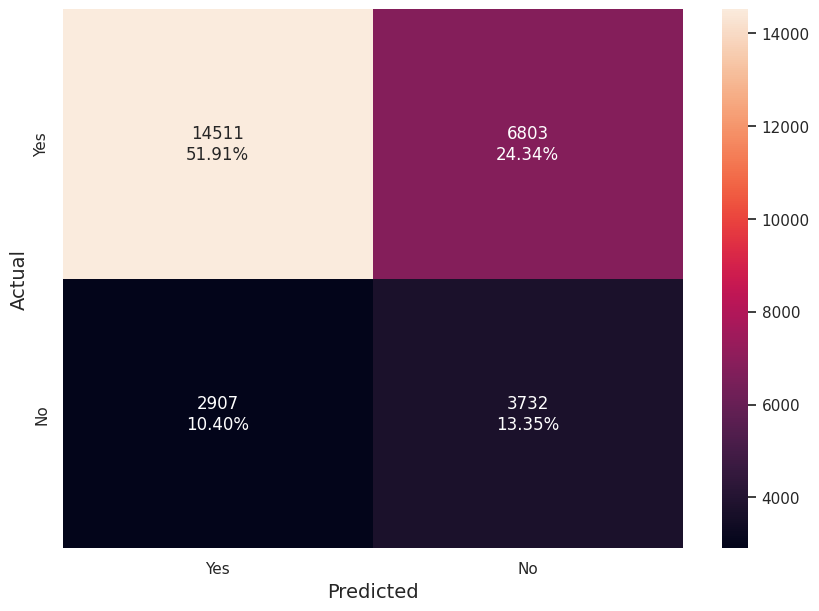

In [ ]:
get_metrics_score(log_reg_over)
make_confusion_matrix(log_reg_over, y_test)

### Regularization

In [ ]:
# Choose the type of classifier.
lr_estimator = LogisticRegression(random_state=1)

# Grid of parameters to choose from
parameters = {'C': np.arange(0.1, 1.1, 0.1)}

# Run the grid search
grid_obj = GridSearchCV(lr_estimator, parameters, scoring='recall', n_jobs=-1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
lr_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
lr_estimator.fit(X_train_over, y_train_over)

LogisticRegression(C=0.30000000000000004, random_state=1)

Metric,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1-Score,Test F1-Score
Score,0.653,0.653,0.561,0.562,0.354,0.354,0.434,0.435


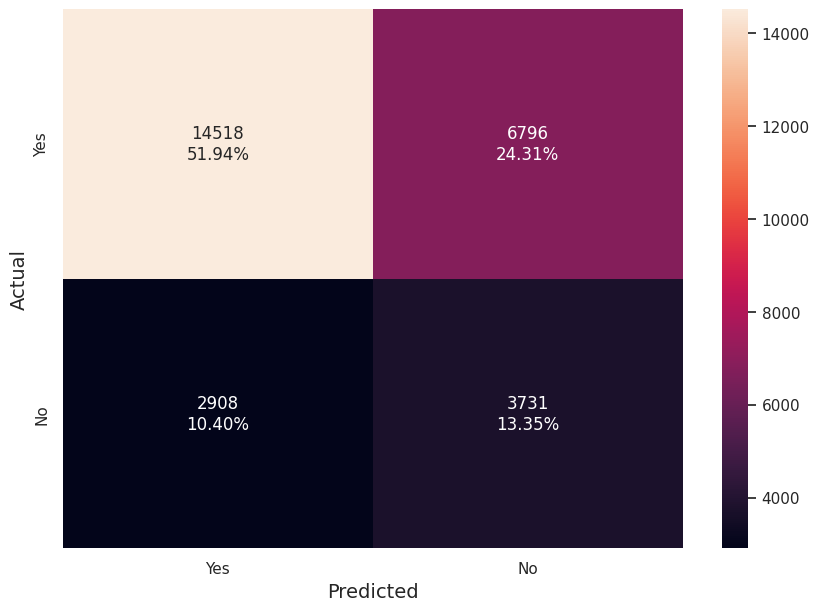

In [ ]:
get_metrics_score(lr_estimator)
make_confusion_matrix(lr_estimator, y_test)

In [ ]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list

models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "BAGGING",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", BaggingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", RandomForestClassifier(random_state=1)),
            ]
        ),
    )
)

models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", AdaBoostClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", XGBClassifier(random_state=1, eval_metric='logloss')),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []   # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold)
    results.append(cv_result)
    names.append(name)

    print(f"{name}: {cv_result.mean() * 100}")

DTREE: 58.56681730148482
BAGGING: 48.84441575209813
RF: 32.027114267269205
ADB: 30.122659780503554
GBM: 32.3692704970949
XGB: 58.99935442220787


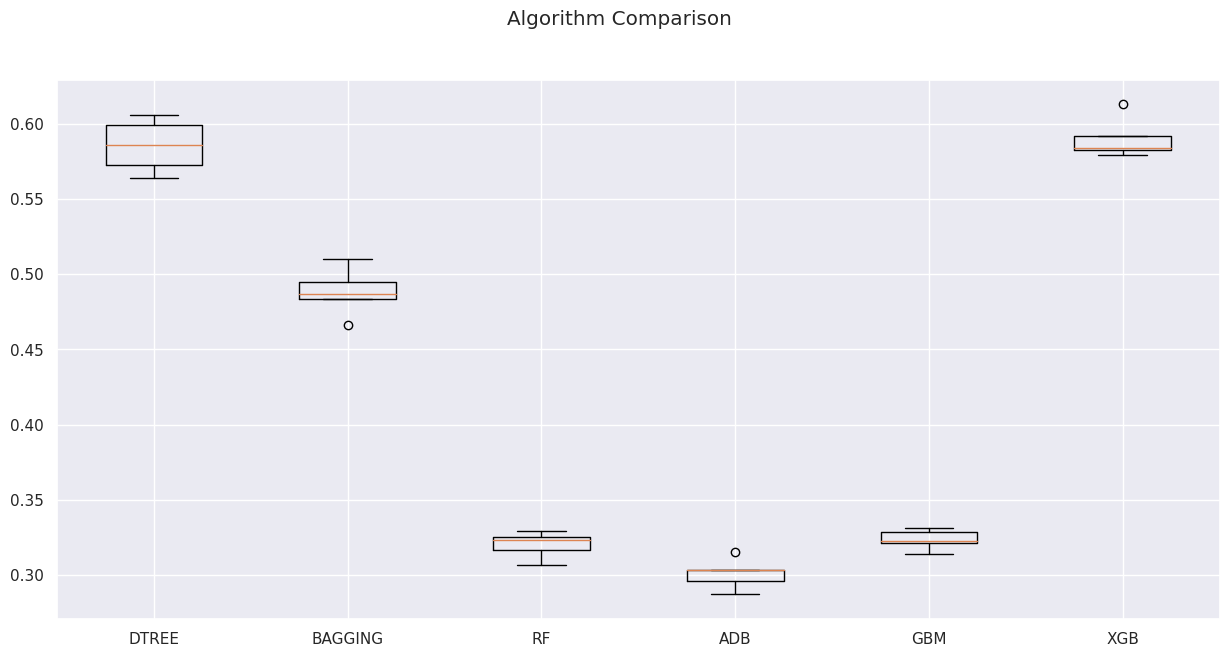

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names);

<a id=xgbc></a>
## <span style="color:blue">XGBoost Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter Tuning using RandomizedSearchCV

In [ ]:
%%time

#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1,eval_metric='logloss', n_estimators=50))

#Parameter grid to pass in RandomizedSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(150,200,250),
            'xgbclassifier__scale_pos_weight':[5,10],
            'xgbclassifier__learning_rate':[0.1,0.2,],
            'xgbclassifier__gamma':[0,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1],
            'xgbclassifier__max_depth':np.arange(1,10,1),
            'xgbclassifier__reg_lambda':[0,1,2,5,10]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=10,
                                   scoring=scorer, cv=5, random_state=1, n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print(f"Best Parameters:{randomized_cv.best_params_} \nScore: {randomized_cv.best_score_}")

Best Parameters:{'xgbclassifier__subsample': 0.7, 'xgbclassifier__scale_pos_weight': 5, 'xgbclassifier__reg_lambda': 0, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 3} 
Score: 0.8610718434555278
CPU times: user 1min 55s, sys: 3.46 s, total: 1min 58s
Wall time: 29min 17s


Metric,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1-Score,Test F1-Score
Score,0.918,0.876,0.835,0.720,0.823,0.747,0.829,0.733


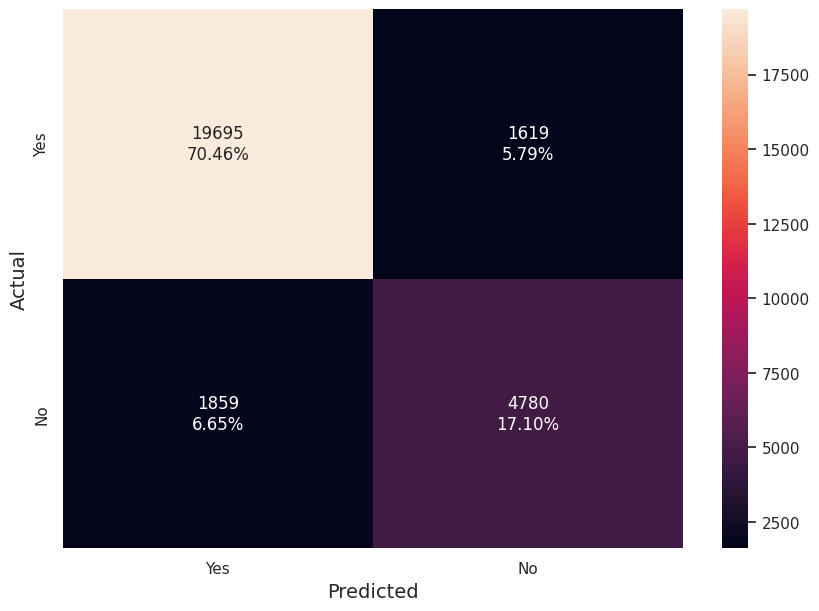

In [ ]:
# Creating new pipeline with best parameters
xgb_tuned = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=150,
        scale_pos_weight=2,
        reg_lambda=2,
        max_depth=7,
        subsample=1,
        learning_rate=0.2,
        gamma=1,
        eval_metric='logloss',
        n_jobs=-1
    )
)

# Fit the model on training data
xgb_tuned.fit(X_train_over, y_train_over)

#Calculating different metrics
get_metrics_score(xgb_tuned)

#Creating confusion matrix
make_confusion_matrix(xgb_tuned, y_test)

<a id=bagging></a>
## <span style="color:blue">Bagging Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter tuning using GridSearchCV

In [ ]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'baggingclassifier__max_samples':  [0.7, 0.8, 0.9, 1],
    'baggingclassifier__max_features': [0.7, 0.8, 0.9, 1],
    'baggingclassifier__n_estimators': [30, 40, 50, 70]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(f"Best Parameters:{grid_cv.best_params_} \nScore: {grid_cv.best_score_}")

KeyboardInterrupt: ignored

In [ ]:
# Creating new pipeline with best parameters
bagg_tuned = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=0.9,
        max_samples=0.9,
        random_state=1,
        n_estimators=50,
        n_jobs=-1
    )
)

# Fit the model on training data
bagg_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(bagg_tuned)

#Creating confusion matrix
make_confusion_matrix(bagg_tuned, y_test)

KeyboardInterrupt: ignored

<a id=dtree></a>
## <span style="color:blue">Decision Tree Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter Tuning using GridSearchCV

In [ ]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'decisiontreeclassifier__max_depth': np.arange(2, 30),
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],
    'decisiontreeclassifier__max_leaf_nodes' : [2, 3, 5, 10, 15],
    'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(f"Best parameters are {grid_cv.best_params_} \nScore={grid_cv.best_score_}:")

In [ ]:
# Creating new pipeline with best parameters
dtree_tuned = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        max_depth=7,
        max_leaf_nodes=15,
        random_state=1,
        min_impurity_decrease=0.0001,
        min_samples_leaf=1,
    )
)

# Fit the model on training data
dtree_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(dtree_tuned)

#Creating confusion matrix
make_confusion_matrix(dtree_tuned, y_test)

<a id=stacking></a>
## <span style="color:blue">Stacking Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [ ]:
estimators = [('Bagging Classifier', bagg_tuned), ('Decision Tree', dtree_tuned)]
stacking_classifier= StackingClassifier(estimators=estimators, final_estimator=xgb_tuned)
stacking_classifier.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(stacking_classifier)

#Creating confusion matrix
make_confusion_matrix(stacking_classifier, y_test)

- I will use xgb_tuned model to predict the test set output variables

<a id=testset></a>
## <span style="color:blue">Test Set Prediction</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Python Project/Test_set.csv') ##  Complete the code to read the data
test.columns

Index(['ID', 'loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')

In [ ]:
test_id = test.ID
test_id.head()

0     4855329
1    66862420
2     3637416
3    53682249
4    53937165
Name: ID, dtype: int64

In [ ]:
test.annual_income.fillna(test.annual_income.mean(), inplace=True)
test.last_week_pay.fillna(test.last_week_pay.mean(), inplace=True)
test.total_current_balance.fillna(test.total_current_balance.mean(), inplace=True)
test.total_revolving_limit.fillna(test.total_revolving_limit.mean(), inplace=True)
test.total_acc.fillna(test.total_acc.mean(), inplace=True)

In [ ]:
job_experience = {'<5 Years':0, '6-10 years':1, '10+ years':2}
test['job_experience'] = test['job_experience'].map(job_experience).astype('Int32')

loan_term = {'3 years': 0, '5 years': 1}
test['loan_term'] = test['loan_term'].map(loan_term).astype('Int32')

loan_grade = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
test['loan_grade'] = test['loan_grade'].map(loan_grade).astype('Int32')

loan_subgrade = {'A1':0,  'A2':1,  'A3':2,  'A4':3,  'A5':4,
                 'B1':5,  'B2':6,  'B3':7,  'B4':8,  'B5':9,
                 'C1':10, 'C2':11, 'C3':12, 'C4':13, 'C5':14,
                 'D1':15, 'D2':16, 'D3':17, 'D4':18, 'D5':19,
                 'E1':20, 'E2':21, 'E3':22, 'E4':23, 'E5':24,
                 'F1':25, 'F2':26, 'F3':27, 'F4':28, 'F5':29,
                 'G1':30, 'G2':31, 'G3':32, 'G4':33, 'G5':34}
test['loan_subgrade'] = test['loan_subgrade'].map(loan_subgrade).astype('Int32')

home_ownership = {'MORTGAGE':0, 'RENT':1, 'OWN':2, 'OTHER':3, 'NONE':4}
test['home_ownership'] = test['home_ownership'].map(home_ownership).astype('Int32')

income_verification_status = {'Verified':0, 'Not Verified':1, 'Source Verified':2}
test['income_verification_status'] = test['income_verification_status'].map(income_verification_status).astype('Int32')

loan_purpose = {'debt_consolidation': 0, 'credit_card':1, 'home_improvement': 2, 'other': 3}
test['loan_purpose'] = test['loan_purpose'].map(loan_purpose).astype('Int32')

application_type = {'INDIVIDUAL': 0, 'JOINT':1}
test['application_type'] = test['application_type'].map(application_type).astype('Int32')

state_code = {'AK':0,  'AL':1,  'AR':2,  'AZ':3,  'CA':4 , 'CO':5,  'CT':6,  'DC':7,  'DE':8,
              'FL':9,  'GA':10, 'HI':11, 'IA':12, 'ID':13, 'IL':14, 'IN':15, 'KS':16, 'KY':17,
              'LA':18, 'MA':19, 'MD':20, 'ME':21, 'MI':22, 'MN':23, 'MO':24, 'MS':25, 'MT':26,
              'NC':27, 'ND':28, 'NE':29, 'NH':30, 'NJ':31, 'NM':32, 'NV':33, 'NY':34, 'OH':35,
              'OK':36, 'OR':37, 'PA':38, 'RI':39, 'SC':40, 'SD':41, 'TN':42, 'TX':43, 'UT':44,
              'VA':45, 'VT':46, 'WA':47, 'WI':48, 'WV':49, 'WY':50}
test['state_code'] = test['state_code'].map(state_code).astype('Int32')

In [ ]:
imputer = KNNImputer(n_neighbors=5)

In [ ]:
try:
    test.drop(['ID'], axis=1, inplace=True)
except:
    print('Already dropped')

In [ ]:
print(test.columns)
test.shape

Index(['loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')


(39933, 21)

In [ ]:
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)
test.head()

,loan_amnt,loan_term,interest_rate,loan_grade,loan_subgrade,job_experience,home_ownership,annual_income,income_verification_status,loan_purpose,...,debt_to_income,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,application_type,last_week_pay,total_current_balance,total_revolving_limit
0,12000.000,0.000,15.310,2.000,11.000,0.000,0.000,73400.000,1.000,0.000,...,14.620,0.000,0.000,22156.000,30.000,2290.240,0.000,87.000,128098.000,25800.000
1,12000.000,0.000,7.260,0.000,3.000,2.000,0.000,105000.000,1.000,1.000,...,11.380,0.000,0.000,7592.000,14.000,202.680,0.000,13.000,269396.000,23600.000
2,15000.000,0.000,14.330,2.000,10.000,1.000,0.000,50000.000,0.000,0.000,...,28.150,0.000,1.000,17983.000,19.000,1166.240,0.000,30.000,220135.000,34100.000
3,12000.000,0.000,9.990,1.000,7.000,1.000,1.000,37000.000,2.000,1.000,...,34.320,0.000,0.000,12262.000,18.000,635.060,0.000,35.000,39436.000,21700.000
4,20150.000,0.000,11.530,1.000,9.000,0.000,1.000,75000.000,2.000,0.000,...,26.740,1.000,0.000,8251.000,11.000,1232.840,0.000,31.000,52764.000,12000.000


In [ ]:
#Checking that no column has missing values in train or test sets
print(test.isna().sum())

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
dtype: int64


In [ ]:
## Function to inverse the encoding
def test_inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    test[y] = np.round(test[y]).map(inv_dict).astype('category')

In [ ]:
test_inverse_mapping(job_experience,'job_experience')
test_inverse_mapping(loan_term,'loan_term')
test_inverse_mapping(loan_grade,'loan_grade')
#inverse_mapping(loan_subgrade,'loan_subgrade')
test_inverse_mapping(home_ownership,'home_ownership')
test_inverse_mapping(income_verification_status,'income_verification_status')
test_inverse_mapping(loan_purpose,'loan_purpose')
test_inverse_mapping(application_type,'application_type')
#inverse_mapping(state_code,'state_code')

In [ ]:
test.head()

,loan_amnt,loan_term,interest_rate,loan_grade,loan_subgrade,job_experience,home_ownership,annual_income,income_verification_status,loan_purpose,...,debt_to_income,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,application_type,last_week_pay,total_current_balance,total_revolving_limit
0,12000.000,3 years,15.310,C,11.000,<5 Years,MORTGAGE,73400.000,Not Verified,debt_consolidation,...,14.620,0.000,0.000,22156.000,30.000,2290.240,INDIVIDUAL,87.000,128098.000,25800.000
1,12000.000,3 years,7.260,A,3.000,10+ years,MORTGAGE,105000.000,Not Verified,credit_card,...,11.380,0.000,0.000,7592.000,14.000,202.680,INDIVIDUAL,13.000,269396.000,23600.000
2,15000.000,3 years,14.330,C,10.000,6-10 years,MORTGAGE,50000.000,Verified,debt_consolidation,...,28.150,0.000,1.000,17983.000,19.000,1166.240,INDIVIDUAL,30.000,220135.000,34100.000
3,12000.000,3 years,9.990,B,7.000,6-10 years,RENT,37000.000,Source Verified,credit_card,...,34.320,0.000,0.000,12262.000,18.000,635.060,INDIVIDUAL,35.000,39436.000,21700.000
4,20150.000,3 years,11.530,B,9.000,<5 Years,RENT,75000.000,Source Verified,debt_consolidation,...,26.740,1.000,0.000,8251.000,11.000,1232.840,INDIVIDUAL,31.000,52764.000,12000.000


In [ ]:
cols = test.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(test[i].value_counts(dropna=False))
    print('*'*30)

3 years    28110
5 years    11823
Name: loan_term, dtype: int64
******************************
B    11551
C    10948
A     6764
D     6237
E     3158
F     1030
G      245
Name: loan_grade, dtype: int64
******************************
<5 Years      17866
10+ years     13272
6-10 years     8795
Name: job_experience, dtype: int64
******************************
MORTGAGE    20008
RENT        15938
OWN          3979
OTHER           6
NONE            2
Name: home_ownership, dtype: int64
******************************
Source Verified    14780
Verified           13195
Not Verified       11958
Name: income_verification_status, dtype: int64
******************************
debt_consolidation    23473
credit_card            9383
other                  4693
home_improvement       2384
Name: loan_purpose, dtype: int64
******************************
INDIVIDUAL    39909
JOINT            24
Name: application_type, dtype: int64
******************************


In [ ]:
test = pd.get_dummies(test, drop_first=True)
test.shape

(39933, 33)

In [ ]:
test.columns

Index(['loan_amnt', 'interest_rate', 'loan_subgrade', 'annual_income',
       'state_code', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'loan_term_5 years',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'job_experience_6-10 years',
       'job_experience_<5 Years', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'income_verification_status_Source Verified',
       'income_verification_status_Verified',
       'loan_purpose_debt_consolidation', 'loan_purpose_home_improvement',
       'loan_purpose_other', 'application_type_JOINT'],
      dtype='object')

In [ ]:
pred = xgb_tuned.predict(test)
print(f"Prediction has length: {len(pred)}")

Prediction has length: 39933


In [ ]:
prediction_dict = {
    'ID': test_id,
    'default': pred
}
submit_df = pd.DataFrame(prediction_dict)
submit_df.head()

,ID,default
0,4855329,1
1,66862420,0
2,3637416,1
3,53682249,0
4,53937165,0


In [ ]:
submit_df.to_csv('submission.csv', index=False)